## Nota sobre los cambios respecto al notebook original

En esta versi√≥n del proyecto, he realizado varios cambios respecto al c√≥digo base proporcionado:

- **Uso de Polars en vez de pandas:**  
  He optado por seguir utilizando Polars para la manipulaci√≥n de datos en Python, ya que es una librer√≠a m√°s eficiente y r√°pida para grandes vol√∫menes de datos, adem√°s de ofrecer una sintaxis moderna y muy potente para an√°lisis y transformaciones.

- **Conexi√≥n a la base de datos con SQLAlchemy:**  
  En lugar de conectores m√°s simples como `mysql-connector` o `pymysql`, sigo utilizando SQLAlchemy, que es m√°s flexible y profesional, y permite una mejor gesti√≥n de conexiones, transacciones y portabilidad del c√≥digo.

- **Gesti√≥n de credenciales con dotenv:**  
  Para evitar exponer contrase√±as y par√°metros sensibles en el c√≥digo, he usado la librer√≠a `python-dotenv` y guardo los datos de conexi√≥n en un archivo `.env`, que est√° excluido del repositorio con `.gitignore` para mayor seguridad.

- **Manejo de errores y c√≥digo m√°s robusto:**  
  Se ha a√±adido control de errores y mensajes informativos en las funciones de consulta para asegurar que cualquier fallo en la conexi√≥n o en las queries sea f√°cil de identificar y depurar, acci√≥n que ayuda mucho para identificar errores de todo tipo.

En definitiva, estos cambios son para seguir un poco la l√≥gica del primer notebook, y seguir usando las mismas librer√≠as y dependencias.


In [1]:
# Importamos todas las dependencias necesarias (a priori)

import pandas as pd
import numpy as np
import polars as pl

from dotenv import load_dotenv
import os

import datetime

from meteostat import Point, Daily
import sqlalchemy as sa
from sqlalchemy import create_engine, text
from sqlalchemy.exc import SQLAlchemyError

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

import plotly.express as px
import matplotlib.pyplot as plt
import missingno as msno

## 1. Consulta a la base de datos

In [2]:
# Paso hecho anteriormente en el notebook 02, he visto que aqu√≠ tambi√©n est√° as√≠ que vuelvo a hacer este paso
class DatabaseConnection:

    # Informaci√≥n necesaria para establecer la conexi√≥n a la BBDD
    def __init__(self):
        load_dotenv()  # Variables de entorno
        port = 3306  # Puerto por defecto de MySQL
        user = os.getenv("DB_USER")
        password = os.getenv("DB_PASSWORD")
        host = os.getenv("DB_HOST")
        nombre_base_datos = os.getenv("DB_NAME") 
        self.engine = create_engine(
            f"mysql+mysqlconnector://{user}:{password}@{host}:{port}/{nombre_base_datos}"
        )

    # Funci√≥n cuyo cometido es consultar una query a la BBDD y devolverla como un dataframe de Polars
    def query_to_polars(self, sql_query):
        try:
            with self.engine.connect() as conn:
                result = conn.execute(text(sql_query))
                columns = result.keys()
                rows = result.fetchall()
                if not rows:
                    print("Consulta ejecutada correctamente pero no hay resultados.")
                    return pl.DataFrame(schema=columns)
                print("Consulta ejecutada correctamente.")
                return pl.DataFrame(rows, schema=columns)
        except SQLAlchemyError as e:
            print(f"Error de SQLAlchemy al ejecutar la consulta:\{e}")
            return None
        except Exception as e:
            print(f"Error inesperado:\{e}")
            return None

# Usamos y probamos la clase
db = DatabaseConnection()

query = """
SELECT *
FROM ventas_diarias_estudio
WHERE ARTICULO = '3960'
"""

ventas_prueba = db.query_to_polars(query)
ventas_prueba




Consulta ejecutada correctamente.


shape: (730, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ familia  ‚îÜ tipo  ‚îÜ fechaVenta ‚îÜ festivo    ‚îÜ ‚Ä¶ ‚îÜ orden_arti ‚îÜ in_fecha_e ‚îÜ cantidad ‚îÜ importe    ‚îÇ
‚îÇ ---      ‚îÜ ---   ‚îÜ ---        ‚îÜ ---        ‚îÜ   ‚îÜ culo_famil ‚îÜ studio     ‚îÜ ---      ‚îÜ ---        ‚îÇ
‚îÇ str      ‚îÜ str   ‚îÜ date       ‚îÜ str        ‚îÜ   ‚îÜ ia         ‚îÜ ---        ‚îÜ f64      ‚îÜ f64        ‚îÇ
‚îÇ          ‚îÜ       ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ ---        ‚îÜ str        ‚îÜ          ‚îÜ            ‚îÇ
‚îÇ          ‚îÜ       ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ i64        ‚îÜ            ‚îÜ          ‚îÜ            ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ BOLLERIA ‚îÜ VENTA ‚îÜ 2021-05-01 ‚îÜ null       ‚îÜ ‚Ä¶ ‚îÜ 1          ‚îÜ S          ‚îÜ 2814.0   ‚îÜ 6522.85196 ‚îÇ
‚îÇ          ‚îÜ       ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ            ‚îÜ          ‚îÜ 3          ‚îÇ
‚îÇ BOLLERIA ‚îÜ VENTA ‚îÜ 2021-05-02 ‚îÜ D√≠a de la  ‚îÜ ‚Ä¶ ‚îÜ 1          ‚îÜ S          ‚îÜ 2583.0   ‚îÜ 5987.39397 ‚îÇ
‚îÇ          ‚îÜ       ‚îÜ            ‚îÜ Madre      ‚îÜ   ‚îÜ            ‚îÜ            ‚îÜ          ‚îÜ 3          ‚îÇ
‚îÇ BOLLERIA ‚îÜ VENTA ‚îÜ 2021-05-03 ‚îÜ D√≠a de la  ‚îÜ ‚Ä¶ ‚îÜ 1          ‚îÜ S          ‚îÜ 1596.0   ‚îÜ 3699.52796 ‚îÇ
‚îÇ          ‚îÜ       ‚îÜ            ‚îÜ Cruz       ‚îÜ   ‚îÜ            ‚îÜ            ‚îÜ          ‚îÜ 1          ‚îÇ
‚îÇ BOLLERIA ‚îÜ VENTA ‚îÜ 2021-05-04 ‚îÜ null       ‚îÜ ‚Ä¶ ‚îÜ 1          ‚îÜ S          ‚îÜ 1659.0   ‚îÜ 3845.56199 ‚îÇ
‚îÇ          ‚îÜ       ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ            ‚îÜ          ‚îÜ 1          ‚îÇ
‚îÇ BOLLERIA ‚îÜ VENTA ‚îÜ 2021-05-05 ‚îÜ null       ‚îÜ ‚Ä¶ ‚îÜ 1          ‚îÜ S          ‚îÜ 2016.0   ‚îÜ 4673.08800 ‚îÇ
‚îÇ          ‚îÜ       ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ            ‚îÜ          ‚îÜ 1          ‚îÇ
‚îÇ ‚Ä¶        ‚îÜ ‚Ä¶     ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶ ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶          ‚îÇ
‚îÇ BOLLERIA ‚îÜ VENTA ‚îÜ 2023-04-26 ‚îÜ null       ‚îÜ ‚Ä¶ ‚îÜ 1          ‚îÜ S          ‚îÜ 1134.0   ‚îÜ 3711.58209 ‚îÇ
‚îÇ          ‚îÜ       ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ            ‚îÜ          ‚îÜ 2          ‚îÇ
‚îÇ BOLLERIA ‚îÜ VENTA ‚îÜ 2023-04-27 ‚îÜ null       ‚îÜ ‚Ä¶ ‚îÜ 1          ‚îÜ S          ‚îÜ 1512.0   ‚îÜ 4948.77612 ‚îÇ
‚îÇ          ‚îÜ       ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ            ‚îÜ          ‚îÜ 3          ‚îÇ
‚îÇ BOLLERIA ‚îÜ VENTA ‚îÜ 2023-04-28 ‚îÜ null       ‚îÜ ‚Ä¶ ‚îÜ 1          ‚îÜ S          ‚îÜ 1281.0   ‚îÜ 4192.71310 ‚îÇ
‚îÇ          ‚îÜ       ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ            ‚îÜ          ‚îÜ 4          ‚îÇ
‚îÇ BOLLERIA ‚îÜ VENTA ‚îÜ 2023-04-29 ‚îÜ null       ‚îÜ ‚Ä¶ ‚îÜ 1          ‚îÜ S          ‚îÜ 1743.0   ‚îÜ 5704.83914 ‚îÇ
‚îÇ          ‚îÜ       ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ            ‚îÜ          ‚îÜ 2          ‚îÇ
‚îÇ BOLLERIA ‚îÜ VENTA ‚îÜ 2023-04-30 ‚îÜ null       ‚îÜ ‚Ä¶ ‚îÜ 1          ‚îÜ S          ‚îÜ 2310.0   ‚îÜ 7560.63018 ‚îÇ
‚îÇ          ‚îÜ       ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ            ‚îÜ          ‚îÜ 8          ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚

In [3]:
# La Query est√° adaptada, usa mi base y mi tabla correcta (nombre)
# IMP: se omiten las columnas irrelevantes -> 'in_fecha_estudio' y 'tipo'
query_daily_and_top = """
SELECT  familia,
        articulo,
        fechaVenta AS fecha_venta,
        festivo,
        precio,
        cantidad,
        importe,
        orden_articulo_familia

FROM ventas_diarias_estudio_completo
"""
# !!ESCRIBIR EL "COMPLETO"!! tenia errores en la carga de datos por no a√±adir el "completo" en la consulta SQL

# Instanciar la clase con la contrase√±a de la BBDD (mejor ocultar la contrase√±a)
db = DatabaseConnection()

# Consultar la query anterior y devolverla como un dataframe de Polars
ventas = db.query_to_polars(query_daily_and_top)

# Convertir 'articulo' a entero en Polars, ya cambi√© el formato a "Date" al insertar las tablas en el primer notebook
ventas = ventas.with_columns([
    pl.col("articulo").cast(pl.Int64)
])

Consulta ejecutada correctamente.


In [4]:
ventas

shape: (10_574, 8)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ familia    ‚îÜ articulo ‚îÜ fecha_venta ‚îÜ festivo ‚îÜ precio    ‚îÜ cantidad   ‚îÜ importe    ‚îÜ orden_arti ‚îÇ
‚îÇ ---        ‚îÜ ---      ‚îÜ ---         ‚îÜ ---     ‚îÜ ---       ‚îÜ ---        ‚îÜ ---        ‚îÜ culo_famil ‚îÇ
‚îÇ str        ‚îÜ i64      ‚îÜ date        ‚îÜ str     ‚îÜ f64       ‚îÜ f64        ‚îÜ f64        ‚îÜ ia         ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ            ‚îÜ ---        ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ            ‚îÜ i64        ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ BOLLERIA   ‚îÜ 3880     ‚îÜ 2021-05-01  ‚îÜ null    ‚îÜ 2.591     ‚îÜ 1995.0     ‚îÜ 5169.04498 ‚îÜ 3          ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ 3          ‚îÜ            ‚îÇ
‚îÇ BOLLERIA   ‚îÜ 3960     ‚îÜ 2021-05-01  ‚îÜ null    ‚îÜ 2.318     ‚îÜ 2814.0     ‚îÜ 6522.85196 ‚îÜ 1          ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ 3          ‚îÜ            ‚îÇ
‚îÇ BOLLERIA   ‚îÜ 5803     ‚îÜ 2021-05-01  ‚îÜ null    ‚îÜ 2.727     ‚îÜ 1659.0     ‚îÜ 4524.09286 ‚îÜ 5          ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ 5          ‚îÜ            ‚îÇ
‚îÇ BOLLERIA   ‚îÜ 6286     ‚îÜ 2021-05-01  ‚îÜ null    ‚îÜ 3.136     ‚îÜ 1155.0     ‚îÜ 3622.08004 ‚îÜ 4          ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ 4          ‚îÜ            ‚îÇ
‚îÇ BOLLERIA   ‚îÜ 6425     ‚îÜ 2021-05-01  ‚îÜ null    ‚îÜ 31.364    ‚îÜ 222.074997 ‚îÜ 6965.15458 ‚îÜ 2          ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ 3          ‚îÜ            ‚îÇ
‚îÇ ‚Ä¶          ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶           ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶          ‚îÇ
‚îÇ PASTELERIA ‚îÜ 6523     ‚îÜ 2023-05-17  ‚îÜ null    ‚îÜ 40.772999 ‚îÜ 84.0       ‚îÜ 3424.93200 ‚îÜ 3          ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ 7          ‚îÜ            ‚îÇ
‚îÇ PASTELERIA ‚îÜ 5403     ‚îÜ 2023-05-18  ‚îÜ null    ‚îÜ 40.772999 ‚îÜ 54.600001  ‚îÜ 2226.20304 ‚îÜ 2          ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ 9          ‚îÜ            ‚îÇ
‚îÇ PASTELERIA ‚îÜ 5404     ‚îÜ 2023-05-18  ‚îÜ null    ‚îÜ 43.5      ‚îÜ 126.0      ‚îÜ 5481.0     ‚îÜ 1          ‚îÇ
‚îÇ PASTELERIA ‚îÜ 6451     ‚îÜ 2023-05-18  ‚îÜ null    ‚îÜ 43.5      ‚îÜ 21.0       ‚îÜ 913.5      ‚îÜ 4          ‚îÇ
‚îÇ PASTELERIA ‚îÜ 6523     ‚îÜ 2023-05-18  ‚îÜ null    ‚îÜ 40.772999 ‚îÜ 21.0       ‚îÜ 856.233002 ‚îÜ 3          ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [5]:
# Voy a realizar una comprobaci√≥n de los tipos de las columnas (experimentaci√≥n con Polars)

for col, dtype in zip(ventas.columns, ventas.dtypes):
    print(f"{col}: {dtype}")

familia: String
articulo: Int64
fecha_venta: Date
festivo: String
precio: Float64
cantidad: Float64
importe: Float64
orden_articulo_familia: Int64


In [6]:
# Compruebo la columna festivo, no recordaba el formato y ahora veo el porqu√© del "String"
print(ventas["festivo"].head(10))

shape: (10,)
Series: 'festivo' [str]
[
	null
	null
	null
	null
	null
	"D√≠a de la Madre"
	"D√≠a de la Madre"
	"D√≠a de la Madre"
	"D√≠a de la Madre"
	"D√≠a de la Madre"
]


In [7]:
# El m√©todo ".select" ser√≠a lo correcto con Polars
print(ventas.select("festivo").unique())

shape: (27, 1)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ festivo                 ‚îÇ
‚îÇ ---                     ‚îÇ
‚îÇ str                     ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ D√≠a del Padre           ‚îÇ
‚îÇ Domingo de Resurrecci√≥n ‚îÇ
‚îÇ Mi√©rcoles Santo         ‚îÇ
‚îÇ Nochevieja              ‚îÇ
‚îÇ D√≠a de San Valent√≠n     ‚îÇ
‚îÇ ‚Ä¶                       ‚îÇ
‚îÇ Martes Santo            ‚îÇ
‚îÇ D√≠a de la Cruz          ‚îÇ
‚îÇ D√≠a de San Juan         ‚îÇ
‚îÇ Navidad                 ‚îÇ
‚îÇ Lunes Santo             ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


## 2. Consulta a [meteostat API](https://dev.meteostat.net/python/daily.html)

Variables que se obtienen:

- **tavg** -> The average air temperature in ¬∞C
- **tmin** -> The minimum air temperature in ¬∞C
- **tmax** -> The maximum air temperature in ¬∞C
- **prcp** -> The daily precipitation total in mm
- **wdir** -> The average wind direction in degrees (¬∞)
- **wspd** -> The average wind speed in km/h
- **pres** -> The average sea-level air pressure in hPa

In [8]:
class DailyWeatherData:

    # Localizaci√≥n de la tienda de la Panader√≠a Salvador Echeverr√≠a
    ECHEVERRIA_SHOP = Point(36.721477644071705, -4.363132134392174)

    # Columnas identificadas como importantes
    IMP_COLUMNS = ['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres']

    # Definici√≥n del horizonte temporal de la consulta a la API
    def __init__(self, start, end=None):
        self.start = DailyWeatherData._to_datetime(start)
        if end is not None:
            self.end = DailyWeatherData._to_datetime(end)
        else:
            self.end = datetime.datetime.now()

    # He tenido errores de formato datetime.datetime y datetime.date (end y start), con la siguiente funci√≥n soluciono el problema (creo que es tema de usar Polars)
    @staticmethod  # Uso un @staticmethod para llamar la clase directamente sin necesidad de crear un objeto antes
    def _to_datetime(dt):
        if isinstance(dt, datetime.datetime):
            return dt
        if isinstance(dt, datetime.date):  # Si es datetime.date, convierto SIEMPRE a datetime.datetime
            return datetime.datetime(dt.year, dt.month, dt.day)
        if hasattr(dt, "to_pydatetime"):  # Por si es Polars
            res = dt.to_pydatetime()
            # Por si meteostat devuelve date igualmente
            if isinstance(res, datetime.date) and not isinstance(res, datetime.datetime):
                return datetime.datetime(res.year, res.month, res.day)
            return res
        raise TypeError(f"No puedo convertir {dt} a datetime.datetime")

    # Se establece que la consulta ser√° diaria, se seleccionan todas las columnas imps y se a√±ade un suff.
    def get_weather_data(self, as_polars=True):   # A√±ado un argumento extra, recibir√© un df de Pandas y tengo que convertirlo a Polars
        start_dt = self._to_datetime(self.start)
        end_dt = self._to_datetime(self.end)
        print("start_dt:", start_dt, type(start_dt))
        print("end_dt:", end_dt, type(end_dt))
        daily_data = Daily(self.ECHEVERRIA_SHOP, start_dt, end_dt)
        data = daily_data.fetch()  # Aqu√≠ devuelve un df de Pandas
        df = data[self.IMP_COLUMNS]
        df.columns = [f"{col}_w" for col in df.columns]  # A√±ado el sufijo para evitar conflictos con algun merge (w=weather)
        df = df.reset_index()
        # Aqu√≠ cambio a Polars
        if as_polars:
            return pl.from_pandas(df)
        else:
            return df
        
        


### Nota sobre fechas y compatibilidad Polars/Meteostat

Al trabajar con **Polars** para el an√°lisis y luego tirar de la API de **Meteostat** para meter datos de tiempo, he tenido que pelearme un poco con los tipos de fecha.

- Cuando sacas el m√≠nimo o m√°ximo de una columna de fechas con Polars, lo que te devuelve es un **`datetime.date`**.
- Pero la librer√≠a Meteostat, para sus consultas, quiere **s√≠ o s√≠ un `datetime.datetime`** (no es lo mismo), porque por dentro resta con `datetime.now()` (que es `datetime.datetime`).

¬øEl resultado si no lo conviertes? Te comes un error del tipo:

TypeError: unsupported operand type(s) for -: 'datetime.datetime' and 'datetime.date'

Con pandas este problema sale menos, porqu√© suele devolver un tipo de fecha m√°s compatible, pero aun as√≠ puede pasar.  
Por eso, lo m√°s seguro es **convertir todo a `datetime.datetime` antes de llamar a Meteostat**, y as√≠ te ahorras sustos y funciona todo bien, uses la librer√≠a que uses para tus datos.

> **Resumen**:  
> Si mezclas varias librer√≠as, revisa siempre qu√© tipo de fecha manejas antes de combinarlas‚Ä¶ as√≠ te evitas quebraderos de cabeza como este üòâ



In [9]:
start_ventas = ventas["fecha_venta"].min()
end_ventas = ventas["fecha_venta"].max()

print(start_ventas)
print(end_ventas)

2021-05-01
2023-05-18


In [10]:
# Vamos a usar las fechas de inicio y fin d√≥nde haya ventas
start_date = datetime.date(2021, 5, 1)
end_date = datetime.date(2023, 5, 18)

weather_getter = DailyWeatherData(start=start_date, end=end_date)
weather = weather_getter.get_weather_data(as_polars=True)
weather



start_dt: 2021-05-01 00:00:00 <class 'datetime.datetime'>
end_dt: 2023-05-18 00:00:00 <class 'datetime.datetime'>


shape: (748, 8)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ time                ‚îÜ tavg_w ‚îÜ tmin_w ‚îÜ tmax_w ‚îÜ prcp_w ‚îÜ wdir_w ‚îÜ wspd_w ‚îÜ pres_w ‚îÇ
‚îÇ ---                 ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÇ
‚îÇ datetime[ns]        ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2021-05-01 00:00:00 ‚îÜ 17.2   ‚îÜ 11.9   ‚îÜ 22.8   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 14.2   ‚îÜ 1014.0 ‚îÇ
‚îÇ 2021-05-02 00:00:00 ‚îÜ 16.3   ‚îÜ 10.8   ‚îÜ 23.2   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 15.7   ‚îÜ 1015.9 ‚îÇ
‚îÇ 2021-05-03 00:00:00 ‚îÜ 15.3   ‚îÜ 12.7   ‚îÜ 20.1   ‚îÜ 6.5    ‚îÜ null   ‚îÜ 9.7    ‚îÜ 1017.7 ‚îÇ
‚îÇ 2021-05-04 00:00:00 ‚îÜ 16.5   ‚îÜ 12.0   ‚îÜ 20.9   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 12.1   ‚îÜ 1018.0 ‚îÇ
‚îÇ 2021-05-05 00:00:00 ‚îÜ 16.7   ‚îÜ 12.3   ‚îÜ 21.7   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 13.8   ‚îÜ 1016.5 ‚îÇ
‚îÇ ‚Ä¶                   ‚îÜ ‚Ä¶      ‚îÜ ‚Ä¶      ‚îÜ ‚Ä¶      ‚îÜ ‚Ä¶      ‚îÜ ‚Ä¶      ‚îÜ ‚Ä¶      ‚îÜ ‚Ä¶      ‚îÇ
‚îÇ 2023-05-14 00:00:00 ‚îÜ 19.4   ‚îÜ 14.1   ‚îÜ 25.5   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 12.6   ‚îÜ 1018.2 ‚îÇ
‚îÇ 2023-05-15 00:00:00 ‚îÜ 23.8   ‚îÜ 15.9   ‚îÜ 32.0   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 15.5   ‚îÜ 1015.5 ‚îÇ
‚îÇ 2023-05-16 00:00:00 ‚îÜ 22.3   ‚îÜ 17.8   ‚îÜ 26.2   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 17.6   ‚îÜ 1013.0 ‚îÇ
‚îÇ 2023-05-17 00:00:00 ‚îÜ 19.2   ‚îÜ 17.2   ‚îÜ 23.0   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 9.5    ‚îÜ 1013.4 ‚îÇ
‚îÇ 2023-05-18 00:00:00 ‚îÜ 17.0   ‚îÜ 13.7   ‚îÜ 22.3   ‚îÜ 13.3   ‚îÜ null   ‚îÜ 14.3   ‚îÜ 1016.2 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [11]:
print(weather.head(5))
print(weather.tail(5))

shape: (5, 8)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ time                ‚îÜ tavg_w ‚îÜ tmin_w ‚îÜ tmax_w ‚îÜ prcp_w ‚îÜ wdir_w ‚îÜ wspd_w ‚îÜ pres_w ‚îÇ
‚îÇ ---                 ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÇ
‚îÇ datetime[ns]        ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2021-05-01 00:00:00 ‚îÜ 17.2   ‚îÜ 11.9   ‚îÜ 22.8   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 14.2   ‚îÜ 1014.0 ‚îÇ
‚îÇ 2021-05-02 00:00:00 ‚îÜ 16.3   ‚îÜ 10.8   ‚î

In [12]:
# Para ver los nulos con Polars es algo m√°s complejo, esta es la metodolog√≠a
nulls_column = weather.select([
    pl.col(col).null_count().alias(col) for col in weather.columns
    ])

print(nulls_column)


shape: (1, 8)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ time ‚îÜ tavg_w ‚îÜ tmin_w ‚îÜ tmax_w ‚îÜ prcp_w ‚îÜ wdir_w ‚îÜ wspd_w ‚îÜ pres_w ‚îÇ
‚îÇ ---  ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÇ
‚îÇ u32  ‚îÜ u32    ‚îÜ u32    ‚îÜ u32    ‚îÜ u32    ‚îÜ u32    ‚îÜ u32    ‚îÜ u32    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 0    ‚îÜ 0      ‚îÜ 0      ‚îÜ 0      ‚îÜ 7      ‚îÜ 748    ‚îÜ 0      ‚îÜ 0      ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ

In [13]:
# D√≠as en qu√© hay valores nulos
days_with_nulls = weather.filter(
    pl.any_horizontal([pl.col(c).is_null() for c in weather.columns])
    )
print(days_with_nulls)

# Se entiende que todos, ya que la direcci√≥n del viento es nula en todas las filas

shape: (748, 8)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ time                ‚îÜ tavg_w ‚îÜ tmin_w ‚îÜ tmax_w ‚îÜ prcp_w ‚îÜ wdir_w ‚îÜ wspd_w ‚îÜ pres_w ‚îÇ
‚îÇ ---                 ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÇ
‚îÇ datetime[ns]        ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2021-05-01 00:00:00 ‚îÜ 17.2   ‚îÜ 11.9   ‚îÜ 22.8   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 14.2   ‚îÜ 1014.0 ‚îÇ
‚îÇ 2021-05-02 00:00:00 ‚îÜ 16.3   ‚îÜ 10.8   

In [14]:
# Fechas espec√≠ficas d√≥nde hay valores nulos en "prcp_w"
prcp_null = weather.filter(pl.col("prcp_w").is_null())  
print(prcp_null[["time", "prcp_w"]])


shape: (7, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ time                ‚îÜ prcp_w ‚îÇ
‚îÇ ---                 ‚îÜ ---    ‚îÇ
‚îÇ datetime[ns]        ‚îÜ f64    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2021-10-26 00:00:00 ‚îÜ null   ‚îÇ
‚îÇ 2021-10-30 00:00:00 ‚îÜ null   ‚îÇ
‚îÇ 2022-01-27 00:00:00 ‚îÜ null   ‚îÇ
‚îÇ 2022-02-28 00:00:00 ‚îÜ null   ‚îÇ
‚îÇ 2022-03-05 00:00:00 ‚îÜ null   ‚îÇ
‚îÇ 2022-04-26 00:00:00 ‚îÜ null   ‚îÇ
‚îÇ 2022-04-27 00:00:00 ‚îÜ null   ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


In [15]:
# Vemos todas las columnas de los d√≠as d√≥nde las precipitaciones s√≥n nulas
print(prcp_null)

shape: (7, 8)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ time                ‚îÜ tavg_w ‚îÜ tmin_w ‚îÜ tmax_w ‚îÜ prcp_w ‚îÜ wdir_w ‚îÜ wspd_w ‚îÜ pres_w ‚îÇ
‚îÇ ---                 ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÇ
‚îÇ datetime[ns]        ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2021-10-26 00:00:00 ‚îÜ 18.3   ‚îÜ 15.6   ‚îÜ 24.1   ‚îÜ null   ‚îÜ null   ‚îÜ 9.6    ‚îÜ 1020.4 ‚îÇ
‚îÇ 2021-10-30 00:00:00 ‚îÜ 21.8   ‚îÜ 17.6   ‚î

In [ ]:
# Ruta para guardar archivos de datos ya procesados
PROCESSED_DATA_DIR = r"d:\PersonalProjects\Panader√≠a Datathon\data\processed"

# Voy a convertir el archivo a csv tambi√©n, ya que Polars tiene m√©todo directo
weather.write_csv(os.path.join(PROCESSED_DATA_DIR, "variables_meteorologicas.csv"))

# En Polars no hay m√©todo directo para convertir a Excel, as√≠ que primero a Pandas
weather_pandas = weather.to_pandas()

weather_pandas.to_excel(os.path.join(PROCESSED_DATA_DIR, "variables_meteorologicas.xlsx"))



## 3. Join -> Datos de ventas y del tiempo

In [17]:
ventas

shape: (10_574, 8)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ familia    ‚îÜ articulo ‚îÜ fecha_venta ‚îÜ festivo ‚îÜ precio    ‚îÜ cantidad   ‚îÜ importe    ‚îÜ orden_arti ‚îÇ
‚îÇ ---        ‚îÜ ---      ‚îÜ ---         ‚îÜ ---     ‚îÜ ---       ‚îÜ ---        ‚îÜ ---        ‚îÜ culo_famil ‚îÇ
‚îÇ str        ‚îÜ i64      ‚îÜ date        ‚îÜ str     ‚îÜ f64       ‚îÜ f64        ‚îÜ f64        ‚îÜ ia         ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ            ‚îÜ ---        ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ            ‚îÜ i64        ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ BOLLERIA   ‚îÜ 3880     ‚îÜ 2021-05-01  ‚îÜ null    ‚îÜ 2.591     ‚îÜ 1995.0     ‚îÜ 5169.04498 ‚îÜ 3          ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ 3          ‚îÜ            ‚îÇ
‚îÇ BOLLERIA   ‚îÜ 3960     ‚îÜ 2021-05-01  ‚îÜ null    ‚îÜ 2.318     ‚îÜ 2814.0     ‚îÜ 6522.85196 ‚îÜ 1          ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ 3          ‚îÜ            ‚îÇ
‚îÇ BOLLERIA   ‚îÜ 5803     ‚îÜ 2021-05-01  ‚îÜ null    ‚îÜ 2.727     ‚îÜ 1659.0     ‚îÜ 4524.09286 ‚îÜ 5          ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ 5          ‚îÜ            ‚îÇ
‚îÇ BOLLERIA   ‚îÜ 6286     ‚îÜ 2021-05-01  ‚îÜ null    ‚îÜ 3.136     ‚îÜ 1155.0     ‚îÜ 3622.08004 ‚îÜ 4          ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ 4          ‚îÜ            ‚îÇ
‚îÇ BOLLERIA   ‚îÜ 6425     ‚îÜ 2021-05-01  ‚îÜ null    ‚îÜ 31.364    ‚îÜ 222.074997 ‚îÜ 6965.15458 ‚îÜ 2          ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ 3          ‚îÜ            ‚îÇ
‚îÇ ‚Ä¶          ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶           ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶          ‚îÇ
‚îÇ PASTELERIA ‚îÜ 6523     ‚îÜ 2023-05-17  ‚îÜ null    ‚îÜ 40.772999 ‚îÜ 84.0       ‚îÜ 3424.93200 ‚îÜ 3          ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ 7          ‚îÜ            ‚îÇ
‚îÇ PASTELERIA ‚îÜ 5403     ‚îÜ 2023-05-18  ‚îÜ null    ‚îÜ 40.772999 ‚îÜ 54.600001  ‚îÜ 2226.20304 ‚îÜ 2          ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ 9          ‚îÜ            ‚îÇ
‚îÇ PASTELERIA ‚îÜ 5404     ‚îÜ 2023-05-18  ‚îÜ null    ‚îÜ 43.5      ‚îÜ 126.0      ‚îÜ 5481.0     ‚îÜ 1          ‚îÇ
‚îÇ PASTELERIA ‚îÜ 6451     ‚îÜ 2023-05-18  ‚îÜ null    ‚îÜ 43.5      ‚îÜ 21.0       ‚îÜ 913.5      ‚îÜ 4          ‚îÇ
‚îÇ PASTELERIA ‚îÜ 6523     ‚îÜ 2023-05-18  ‚îÜ null    ‚îÜ 40.772999 ‚îÜ 21.0       ‚îÜ 856.233002 ‚îÜ 3          ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [18]:
weather

shape: (748, 8)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ time                ‚îÜ tavg_w ‚îÜ tmin_w ‚îÜ tmax_w ‚îÜ prcp_w ‚îÜ wdir_w ‚îÜ wspd_w ‚îÜ pres_w ‚îÇ
‚îÇ ---                 ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÇ
‚îÇ datetime[ns]        ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2021-05-01 00:00:00 ‚îÜ 17.2   ‚îÜ 11.9   ‚îÜ 22.8   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 14.2   ‚îÜ 1014.0 ‚îÇ
‚îÇ 2021-05-02 00:00:00 ‚îÜ 16.3   ‚îÜ 10.8   ‚îÜ 23.2   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 15.7   ‚îÜ 1015.9 ‚îÇ
‚îÇ 2021-05-03 00:00:00 ‚îÜ 15.3   ‚îÜ 12.7   ‚îÜ 20.1   ‚îÜ 6.5    ‚îÜ null   ‚îÜ 9.7    ‚îÜ 1017.7 ‚îÇ
‚îÇ 2021-05-04 00:00:00 ‚îÜ 16.5   ‚îÜ 12.0   ‚îÜ 20.9   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 12.1   ‚îÜ 1018.0 ‚îÇ
‚îÇ 2021-05-05 00:00:00 ‚îÜ 16.7   ‚îÜ 12.3   ‚îÜ 21.7   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 13.8   ‚îÜ 1016.5 ‚îÇ
‚îÇ ‚Ä¶                   ‚îÜ ‚Ä¶      ‚îÜ ‚Ä¶      ‚îÜ ‚Ä¶      ‚îÜ ‚Ä¶      ‚îÜ ‚Ä¶      ‚îÜ ‚Ä¶      ‚îÜ ‚Ä¶      ‚îÇ
‚îÇ 2023-05-14 00:00:00 ‚îÜ 19.4   ‚îÜ 14.1   ‚îÜ 25.5   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 12.6   ‚îÜ 1018.2 ‚îÇ
‚îÇ 2023-05-15 00:00:00 ‚îÜ 23.8   ‚îÜ 15.9   ‚îÜ 32.0   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 15.5   ‚îÜ 1015.5 ‚îÇ
‚îÇ 2023-05-16 00:00:00 ‚îÜ 22.3   ‚îÜ 17.8   ‚îÜ 26.2   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 17.6   ‚îÜ 1013.0 ‚îÇ
‚îÇ 2023-05-17 00:00:00 ‚îÜ 19.2   ‚îÜ 17.2   ‚îÜ 23.0   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 9.5    ‚îÜ 1013.4 ‚îÇ
‚îÇ 2023-05-18 00:00:00 ‚îÜ 17.0   ‚îÜ 13.7   ‚îÜ 22.3   ‚îÜ 13.3   ‚îÜ null   ‚îÜ 14.3   ‚îÜ 1016.2 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [19]:
# Las columnas de join tienen que tener el mismo tipo, "fecha_venta" y "time"
ventas = ventas.with_columns(pl.col("fecha_venta").cast(pl.Date))

# El m√©todo .cast en Polars, convierte las columnas en el tipo que le indicamos
weather = weather.with_columns(pl.col("time").cast(pl.Date))

df_join = ventas.join(
    weather,
    left_on="fecha_venta",
    right_on="time",
    how="inner"
)

    

# Ordenar el df por "articulo" y la "fecha_venta"
df = df_join.sort(["articulo", "fecha_venta"])
df.head(5)

shape: (5, 15)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ familia   ‚îÜ articulo ‚îÜ fecha_venta ‚îÜ festivo         ‚îÜ ‚Ä¶ ‚îÜ prcp_w ‚îÜ wdir_w ‚îÜ wspd_w ‚îÜ pres_w ‚îÇ
‚îÇ ---       ‚îÜ ---      ‚îÜ ---         ‚îÜ ---             ‚îÜ   ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÇ
‚îÇ str       ‚îÜ i64      ‚îÜ date        ‚îÜ str             ‚îÜ   ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ PANADERIA ‚îÜ 417      ‚îÜ 2021-05-01  ‚îÜ null            ‚îÜ ‚Ä¶ ‚îÜ 0.0    ‚îÜ null   ‚îÜ 14.2   ‚îÜ 1014.0 ‚îÇ
‚îÇ PANADERIA ‚îÜ 417      ‚îÜ 2021-05-02  ‚îÜ D√≠a de la Madre ‚îÜ ‚Ä¶ ‚îÜ 0.0    ‚îÜ null   ‚îÜ 15.7   ‚îÜ 1015.9 ‚îÇ
‚îÇ PANADERIA ‚îÜ 417      ‚îÜ 2021-05-03  ‚îÜ D√≠a de la Cruz  ‚îÜ ‚Ä¶ ‚îÜ 6.5    ‚îÜ null   ‚îÜ 9.7    ‚îÜ 1017.7 ‚îÇ
‚îÇ PANADERIA ‚îÜ 417      ‚îÜ 2021-05-04  ‚îÜ null            ‚îÜ ‚Ä¶ ‚îÜ 0.0    ‚îÜ null   ‚îÜ 12.1   ‚îÜ 1018.0 ‚îÇ
‚îÇ PANADERIA ‚îÜ 417      ‚îÜ 2021-05-05  ‚îÜ null            ‚îÜ ‚Ä¶ ‚îÜ 0.0    ‚îÜ null   ‚îÜ 13.8   ‚îÜ 1016.5 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

## 4. EDA

#### 4.1. Inspecci√≥n inicial

Este apartado tiene como cometido comprender la estructura del conjunto de datos y ver posibles problemas de calidad que podr√≠an afectar al an√°lisis.

**Grupo de preguntas 1** (x minutos):

1. Describe que significa cada fila de nuestro conjunto de datos.

2. ¬øCu√°ntos valores √∫nicos hay en cada una de las variables? ¬øQu√© insight podr√≠as observar al comparar los valores √∫nicos de la variable "articulo" con los valores √∫nicos de la variable "precio"?

3. ¬øCu√°ntos valores nulos hay en cada una de las variables?

4. ¬øHay duplicados?

In [65]:
# 1
example = df.head(1)
display(example)

shape: (1, 15)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ familia   ‚îÜ articulo ‚îÜ fecha_venta ‚îÜ festivo ‚îÜ ‚Ä¶ ‚îÜ prcp_w ‚îÜ wdir_w ‚îÜ wspd_w ‚îÜ pres_w ‚îÇ
‚îÇ ---       ‚îÜ ---      ‚îÜ ---         ‚îÜ ---     ‚îÜ   ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÇ
‚îÇ str       ‚îÜ i64      ‚îÜ date        ‚îÜ str     ‚îÜ   ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ PANADERIA ‚îÜ 417      ‚îÜ 2021-05-01  ‚îÜ null    ‚îÜ ‚Ä¶ ‚îÜ 0.0    ‚îÜ null   ‚îÜ 14.2   ‚îÜ 1014.0 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [ ]:
# 1
print(df.schema)

Schema([('familia', String), ('articulo', Int64), ('fecha_venta', Date), ('festivo', String), ('precio', Float64), ('cantidad', Float64), ('importe', Float64), ('orden_articulo_familia', Int64), ('tavg_w', Float64), ('tmin_w', Float64), ('tmax_w', Float64), ('prcp_w', Float64), ('wdir_w', Float64), ('wspd_w', Float64), ('pres_w', Float64)])


**Cada fila del conjunto de datos representa las ventas de un art√≠culo concreto en un d√≠a determinado en la Panader√≠a Salvador, incluyendo informaci√≥n de la venta y variables meteorol√≥gicas asociadas a ese d√≠a.**

In [ ]:
# 2_Valores √∫nicos por variable  (Seguimos con Polars)
{col: df[col].n_unique() for col in df.columns}

{'familia': 3,
 'articulo': 15,
 'fecha_venta': 748,
 'festivo': 27,
 'precio': 65,
 'cantidad': 1418,
 'importe': 6303,
 'orden_articulo_familia': 5,
 'tavg_w': 200,
 'tmin_w': 214,
 'tmax_w': 221,
 'prcp_w': 60,
 'wdir_w': 1,
 'wspd_w': 197,
 'pres_w': 217}

In [ ]:
# 2_Relaci√≥n "art√≠culo" y "precio", para ver precios distintos que ha tenido cada art√≠culo
prices_item = df.group_by("articulo").agg([
    pl.col("precio").n_unique().alias("precios_unicos")
]).sort("precios_unicos", descending=True)

prices_item.head(10)

# Haciendo la comparaci√≥n entre precios √∫nicos y "art√≠culo", vemos como el precio ha cambiado a lo largo del tiempo

# Si alg√∫n art√≠culo tiene m√°s de un precio √∫nico, indica que su precio ha variado


shape: (10, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ articulo ‚îÜ precios_unicos ‚îÇ
‚îÇ ---      ‚îÜ ---            ‚îÇ
‚îÇ i64      ‚îÜ u32            ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 6425     ‚îÜ 24             ‚îÇ
‚îÇ 5404     ‚îÜ 7              ‚îÇ
‚îÇ 968      ‚îÜ 5              ‚îÇ
‚îÇ 1043     ‚îÜ 5              ‚îÇ
‚îÇ 5403     ‚îÜ 5              ‚îÇ
‚îÇ 6286     ‚îÜ 5              ‚îÇ
‚îÇ 417      ‚îÜ 4              ‚îÇ
‚îÇ 1084     ‚îÜ 4              ‚îÇ
‚îÇ 3880     ‚îÜ 4              ‚îÇ
‚îÇ 3960     ‚îÜ 4              ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [ ]:
# 3_Vamos a ver los valores nulos por columna
nulls_per_column = df.select([
    pl.col(col).null_count().alias(col) for col in df.columns
])
print(nulls_per_column)

shape: (1, 15)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ familia ‚îÜ articulo ‚îÜ fecha_venta ‚îÜ festivo ‚îÜ ‚Ä¶ ‚îÜ prcp_w ‚îÜ wdir_w ‚îÜ wspd_w ‚îÜ pres_w ‚îÇ
‚îÇ ---     ‚îÜ ---      ‚îÜ ---         ‚îÜ ---     ‚îÜ   ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÇ
‚îÇ u32     ‚îÜ u32      ‚îÜ u32         ‚îÜ u32     ‚îÜ   ‚îÜ u32    ‚îÜ u32    ‚îÜ u32    ‚îÜ u32    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 0       ‚îÜ 0        ‚îÜ 0           ‚îÜ 9737    ‚îÜ ‚Ä¶ ‚îÜ 97     ‚îÜ 10574  ‚îÜ 0      ‚îÜ 0      ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚î

<Axes: >

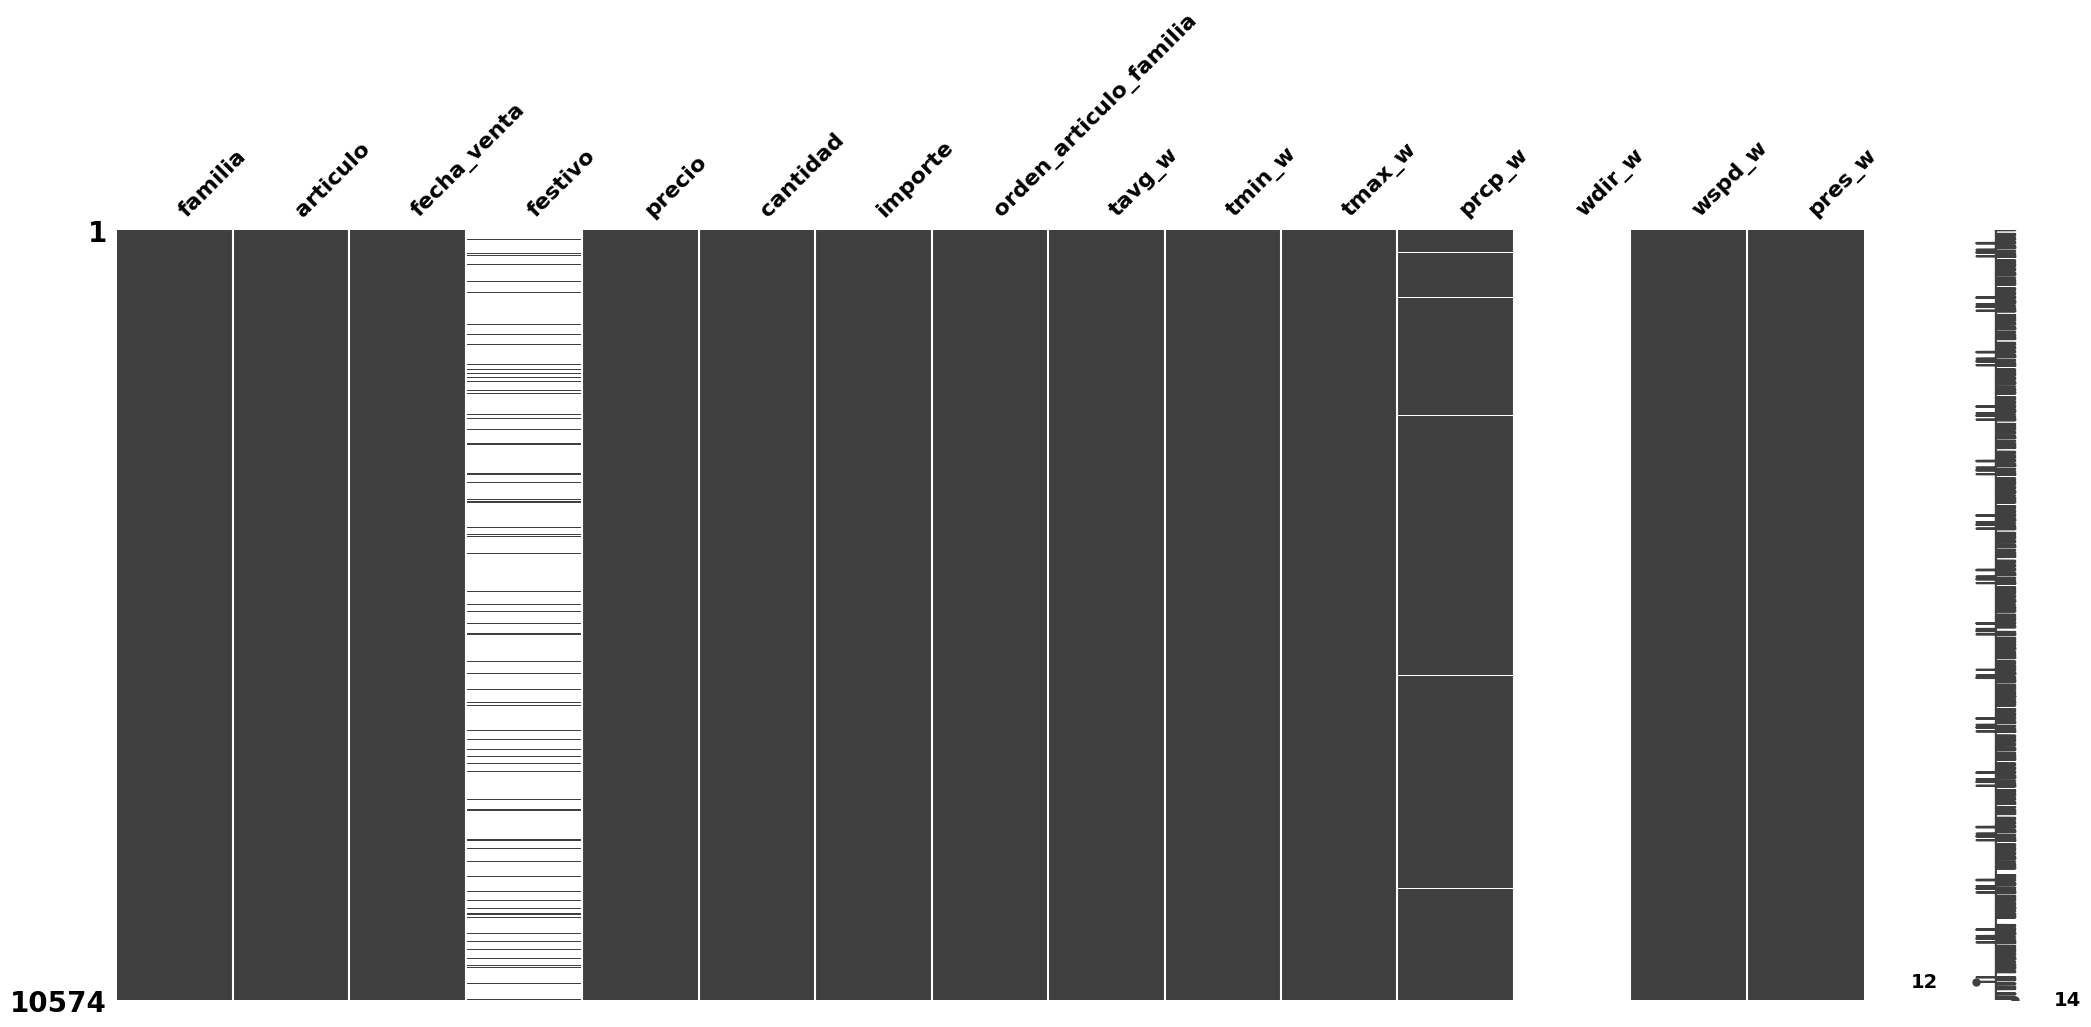

In [ ]:
# 3_Gr√°fica visual de valores nulos, tengo que usar el m√©todo .to_pandas
msno.matrix(df.to_pandas())

In [ ]:
# 4_Vamos a comprobar si hay duplicados
num_duplicated = df.is_duplicated().sum()
print(f"N√∫mero de filas duplicadas: {num_duplicated}")

N√∫mero de filas duplicadas: 0


In [ ]:
# 4_Encuentra duplicados por varias columnas en Polars (sin argumento 'subset', solo los nombres de columnas)
# Creo una columna temporal que concatene fecha_venta y articulo
# Me est√° dando bastante problemas Polars
df_ext = df.with_columns(
    (pl.col("fecha_venta").cast(pl.Utf8) + "_" + pl.col("articulo").cast(pl.Utf8)).alias("fecha_articulo")
)

# Busco duplicados de la columna
duplicated_mask = df_ext["fecha_articulo"].is_duplicated()
# Filtro para ver solo las filas duplicadas
df_double = df_ext.filter(duplicated_mask)

# Visualizo sin la columna temporal
print(df_double.drop("fecha_articulo"))


shape: (0, 15)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ familia ‚îÜ articulo ‚îÜ fecha_venta ‚îÜ festivo ‚îÜ ‚Ä¶ ‚îÜ prcp_w ‚îÜ wdir_w ‚îÜ wspd_w ‚îÜ pres_w ‚îÇ
‚îÇ ---     ‚îÜ ---      ‚îÜ ---         ‚îÜ ---     ‚îÜ   ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÇ
‚îÇ str     ‚îÜ i64      ‚îÜ date        ‚îÜ str     ‚îÜ   ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ

Al buscar filas duplicadas por las columnas "fecha_venta" y "articulo", el DataFrame resultante est√° vac√≠o. Por tanto, podemos afirmar que no existen duplicados para esta combinaci√≥n de claves.


In [26]:
# Voy a definir los tipos n√∫mericos, ya que polars no tiene el m√©todo "is_numeric_dtype"

# (Me estoy empezando a arrepentir de usar Polars)

# Num. types
numeric_types = [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64, pl.Float32, pl.Float64]

# Pruebo la definici√≥n
numeric_cols = [col for col in df.columns if df[col].dtype in numeric_types]
df.select(numeric_cols).describe()

shape: (9, 13)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ statistic  ‚îÜ articulo   ‚îÜ precio    ‚îÜ cantidad  ‚îÜ ‚Ä¶ ‚îÜ prcp_w   ‚îÜ wdir_w  ‚îÜ wspd_w    ‚îÜ pres_w    ‚îÇ
‚îÇ ---        ‚îÜ ---        ‚îÜ ---       ‚îÜ ---       ‚îÜ   ‚îÜ ---      ‚îÜ ---     ‚îÜ ---       ‚îÜ ---       ‚îÇ
‚îÇ str        ‚îÜ f64        ‚îÜ f64       ‚îÜ f64       ‚îÜ   ‚îÜ f64      ‚îÜ f64     ‚îÜ f64       ‚îÜ f64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ count      ‚îÜ 10574.0    ‚îÜ 10574.0   ‚îÜ 10574.0   ‚îÜ ‚Ä¶ ‚îÜ 10477.0  ‚îÜ 0.0     ‚îÜ 10574.0   ‚îÜ 10574.0   ‚îÇ
‚îÇ null_count ‚îÜ 0.0        ‚îÜ 0.0       ‚îÜ 0.0       ‚îÜ ‚Ä¶ ‚îÜ 97.0     ‚îÜ 10574.0 ‚îÜ 0.0       ‚îÜ 0.0       ‚îÇ
‚îÇ mean       ‚îÜ 3945.09173 ‚îÜ 15.414053 ‚îÜ 963.81567 ‚îÜ ‚Ä¶ ‚îÜ 0.793118 ‚îÜ null    ‚îÜ 14.323492 ‚îÜ 1018.0159 ‚îÇ
‚îÇ            ‚îÜ 4          ‚îÜ           ‚îÜ 2         ‚îÜ   ‚îÜ          ‚îÜ         ‚îÜ           ‚îÜ 92        ‚îÇ
‚îÇ std        ‚îÜ 2404.63037 ‚îÜ 17.003998 ‚îÜ 1037.1519 ‚îÜ ‚Ä¶ ‚îÜ 4.279853 ‚îÜ null    ‚îÜ 5.313389  ‚îÜ 5.113184  ‚îÇ
‚îÇ            ‚îÜ 3          ‚îÜ           ‚îÜ 96        ‚îÜ   ‚îÜ          ‚îÜ         ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ min        ‚îÜ 417.0      ‚îÜ 0.865     ‚îÜ 8.4       ‚îÜ ‚Ä¶ ‚îÜ 0.0      ‚îÜ null    ‚îÜ 6.1       ‚îÜ 1004.4    ‚îÇ
‚îÇ 25%        ‚îÜ 1043.0     ‚îÜ 2.591     ‚îÜ 105.0     ‚îÜ ‚Ä¶ ‚îÜ 0.0      ‚îÜ null    ‚îÜ 10.9      ‚îÜ 1014.5    ‚îÇ
‚îÇ 50%        ‚îÜ 5403.0     ‚îÜ 3.545     ‚îÜ 588.0     ‚îÜ ‚Ä¶ ‚îÜ 0.0      ‚îÜ null    ‚îÜ 12.5      ‚îÜ 1017.2    ‚îÇ
‚îÇ 75%        ‚îÜ 6286.0     ‚îÜ 34.091    ‚îÜ 1533.0    ‚îÜ ‚Ä¶ ‚îÜ 0.0      ‚îÜ null    ‚îÜ 16.8      ‚îÜ 1021.0    ‚îÇ
‚îÇ max        ‚îÜ 6549.0     ‚îÜ 43.5      ‚îÜ 7770.0    ‚îÜ ‚Ä¶ ‚îÜ 46.8     ‚îÜ null    ‚îÜ 46.5      ‚îÜ 1032.8    ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [27]:
# Resumen de los datos, he necesitado pasarlo todo a String, si no daba error ya que Polars es bastante exigente con los tipos


summary_dict = {
    "Columna": [str(col) for col in df.columns],
    "Tipo": [str(df[col].dtype) for col in df.columns],
    "Cardinalidad": [str(df[col].n_unique()) for col in df.columns],
    "Granularidad (%)": [str(round(df[col].n_unique() / df.height * 100, 2)) for col in df.columns],
    "Nulos_Pct (%)": [str(round(df[col].null_count() /df.height * 100, 2)) for col in df.columns],
    "Max": [str(df[col].max()) if df[col].dtype in numeric_types else None for col in df.columns],
    "Min": [str(df[col].min()) if df[col].dtype in numeric_types else None for col in df.columns]
}

summary = pl.DataFrame(summary_dict)

summary

shape: (15, 7)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ Columna     ‚îÜ Tipo    ‚îÜ Cardinalidad ‚îÜ Granularidad    ‚îÜ Nulos_Pct (%) ‚îÜ Max    ‚îÜ Min            ‚îÇ
‚îÇ ---         ‚îÜ ---     ‚îÜ ---          ‚îÜ (%)             ‚îÜ ---           ‚îÜ ---    ‚îÜ ---            ‚îÇ
‚îÇ str         ‚îÜ str     ‚îÜ str          ‚îÜ ---             ‚îÜ str           ‚îÜ str    ‚îÜ str            ‚îÇ
‚îÇ             ‚îÜ         ‚îÜ              ‚îÜ str             ‚îÜ               ‚îÜ        ‚îÜ                ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ familia     ‚îÜ String  ‚îÜ 3            ‚îÜ 0.03            ‚îÜ 0.0           ‚îÜ null   ‚îÜ null           ‚îÇ
‚îÇ articulo    ‚îÜ Int64   ‚îÜ 15           ‚îÜ 0.14            ‚îÜ 0.0           ‚îÜ 6549   ‚îÜ 417            ‚îÇ
‚îÇ fecha_venta ‚îÜ Date    ‚îÜ 748          ‚îÜ 7.07            ‚îÜ 0.0           ‚îÜ null   ‚îÜ null           ‚îÇ
‚îÇ festivo     ‚îÜ String  ‚îÜ 27           ‚îÜ 0.26            ‚îÜ 92.08         ‚îÜ null   ‚îÜ null           ‚îÇ
‚îÇ precio      ‚îÜ Float64 ‚îÜ 65           ‚îÜ 0.61            ‚îÜ 0.0           ‚îÜ 43.5   ‚îÜ 0.865000009536 ‚îÇ
‚îÇ             ‚îÜ         ‚îÜ              ‚îÜ                 ‚îÜ               ‚îÜ        ‚îÜ 7432           ‚îÇ
‚îÇ ‚Ä¶           ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶            ‚îÜ ‚Ä¶               ‚îÜ ‚Ä¶             ‚îÜ ‚Ä¶      ‚îÜ ‚Ä¶              ‚îÇ
‚îÇ tmax_w      ‚îÜ Float64 ‚îÜ 221          ‚îÜ 2.09            ‚îÜ 0.0           ‚îÜ 42.6   ‚îÜ 13.3           ‚îÇ
‚îÇ prcp_w      ‚îÜ Float64 ‚îÜ 60           ‚îÜ 0.57            ‚îÜ 0.92          ‚îÜ 46.8   ‚îÜ 0.0            ‚îÇ
‚îÇ wdir_w      ‚îÜ Float64 ‚îÜ 1            ‚îÜ 0.01            ‚îÜ 100.0         ‚îÜ None   ‚îÜ None           ‚îÇ
‚îÇ wspd_w      ‚îÜ Float64 ‚îÜ 197          ‚îÜ 1.86            ‚îÜ 0.0           ‚îÜ 46.5   ‚îÜ 6.1            ‚îÇ
‚îÇ pres_w      ‚îÜ Float64 ‚îÜ 217          ‚îÜ 2.05            ‚îÜ 0.0           ‚îÜ 1032.8 ‚îÜ 1004.4         ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

**Grupo de preguntas 2** (x minutos):

5. ¬øCu√°l es el rango de fechas de nuestro conjunto de datos? Si se divide por producto, ¬øhay fechas faltantes? Crea un gr√°fico de evoluci√≥n temporal para la variable "cantidad" que muestre el producto "6549".

6. Separando por producto, ¬øhay outliers en la variable "cantidad"?

In [ ]:
# 5_Recordar rango de fechas
print(df["fecha_venta"].min(), df["fecha_venta"].max())

print(f"Fecha m√≠nima: {df['fecha_venta'].min()}")
print(f"Fecha m√°xima: {df['fecha_venta'].max()}")



2021-05-01 2023-05-18
Fecha m√≠nima: 2021-05-01
Fecha m√°xima: 2023-05-18


In [29]:
# Comprobar si hay fechas faltantes por producto

all_dates = pl.date_range(
    start=df["fecha_venta"].min(),
    end=df["fecha_venta"].max(),
    interval="1d",
    eager=True
)

# Funci√≥n para ver fechas faltantes para cada producto
id_product = 6549
product_date = df.filter(pl.col("articulo") == id_product)["fecha_venta"].unique()
missing_date = set(all_dates.to_list()) - set(product_date.to_list())

print(f"Fechas faltantes para el producto {id_product}:")
print(sorted(missing_date))
print(f"Total d√≠as sin datos: {len(missing_date)}")




Fechas faltantes para el producto 6549:
[datetime.date(2021, 5, 3), datetime.date(2021, 5, 4), datetime.date(2021, 5, 5), datetime.date(2021, 5, 6), datetime.date(2021, 5, 10), datetime.date(2021, 5, 11), datetime.date(2021, 5, 18), datetime.date(2021, 5, 19), datetime.date(2021, 5, 20), datetime.date(2021, 5, 25), datetime.date(2021, 5, 26), datetime.date(2021, 6, 1), datetime.date(2021, 6, 2), datetime.date(2021, 6, 7), datetime.date(2021, 6, 8), datetime.date(2021, 6, 10), datetime.date(2021, 6, 15), datetime.date(2021, 6, 16), datetime.date(2021, 6, 17), datetime.date(2021, 7, 1), datetime.date(2021, 7, 8), datetime.date(2021, 7, 12), datetime.date(2021, 7, 13), datetime.date(2021, 7, 14), datetime.date(2021, 7, 19), datetime.date(2021, 7, 22), datetime.date(2021, 7, 28), datetime.date(2021, 7, 29), datetime.date(2021, 8, 2), datetime.date(2021, 8, 3), datetime.date(2021, 8, 4), datetime.date(2021, 8, 5), datetime.date(2021, 8, 17), datetime.date(2021, 8, 18), datetime.date(2021, 8

In [46]:
# Hecha la anterior celda, con la funci√≥n para un producto, har√© la funci√≥n para todos los productos
full_dates = pl.date_range(
    start=df["fecha_venta"].min(),
    end=df["fecha_venta"].max(),
    interval="1d",
    eager=True
).to_list()

# Lista de productos √∫nicos
products = df["articulo"].unique().to_list()

# Dict para guardar fechas faltantes
missing_dates = {}

for prod in products:
    prod_dates = df.filter(pl.col("articulo") == prod)["fecha_venta"].unique().to_list()
    missing = sorted(set(full_dates) - set(prod_dates))
    if missing:  # Solo deber√≠a guardar si faltan fechas
        missing_dates[prod] = missing

# Muestra resultado resumido
print(f"Productos con fechas faltantes: {len(missing_dates)} de {len(products)} productos\n")
for prod, missing in missing_dates.items():
    print(f"Producto {prod}: {len(missing)} fechas faltantes")




Productos con fechas faltantes: 8 de 15 productos

Producto 5403: 107 fechas faltantes
Producto 5404: 98 fechas faltantes
Producto 5803: 3 fechas faltantes
Producto 6286: 2 fechas faltantes
Producto 6425: 1 fechas faltantes
Producto 6451: 74 fechas faltantes
Producto 6523: 49 fechas faltantes
Producto 6549: 312 fechas faltantes


In [31]:
# Para ver fechas concretas para cada uno
example = list(missing_dates.keys())[0] if missing_dates else None
if example:
    print(f"\nFechas faltantes para el producto {example}:")
    print(missing_dates[example])


Fechas faltantes para el producto 5403:
[datetime.date(2021, 5, 13), datetime.date(2021, 5, 19), datetime.date(2021, 5, 25), datetime.date(2021, 5, 27), datetime.date(2021, 6, 2), datetime.date(2021, 6, 15), datetime.date(2021, 6, 17), datetime.date(2021, 6, 29), datetime.date(2021, 7, 7), datetime.date(2021, 7, 20), datetime.date(2021, 8, 3), datetime.date(2021, 8, 12), datetime.date(2021, 8, 13), datetime.date(2021, 10, 13), datetime.date(2021, 10, 25), datetime.date(2021, 10, 27), datetime.date(2021, 11, 8), datetime.date(2021, 11, 18), datetime.date(2021, 11, 23), datetime.date(2021, 11, 25), datetime.date(2021, 12, 2), datetime.date(2021, 12, 9), datetime.date(2021, 12, 12), datetime.date(2021, 12, 14), datetime.date(2021, 12, 15), datetime.date(2022, 1, 5), datetime.date(2022, 1, 6), datetime.date(2022, 1, 7), datetime.date(2022, 1, 18), datetime.date(2022, 1, 28), datetime.date(2022, 2, 2), datetime.date(2022, 2, 9), datetime.date(2022, 2, 14), datetime.date(2022, 2, 15), datet

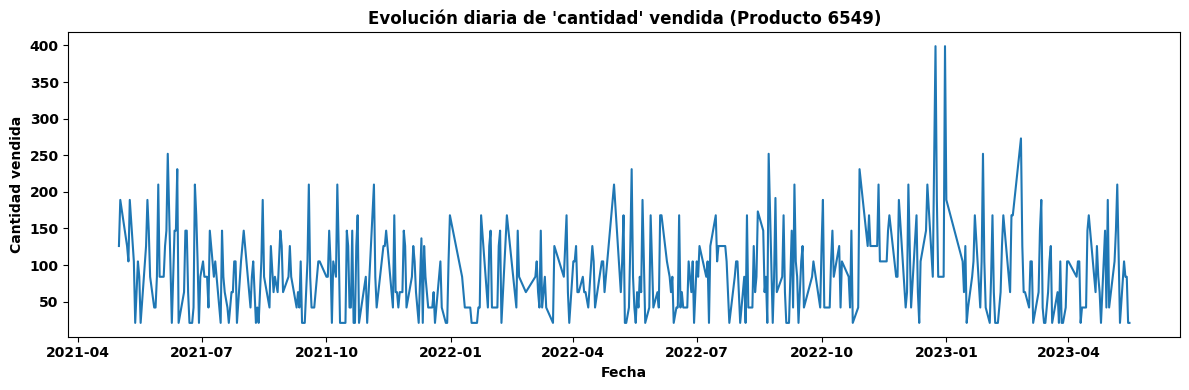

In [72]:
PLOTS_EDA_DIR = r"d:\PersonalProjects\Panader√≠a Datathon\outputs\plots\eda"

# Gr√°fico de evoluci√≥n temporal para el producto 6549

# Filtro datos del producto y los ordeno por fecha
df_6549 = df.filter(pl.col("articulo") == 6549).sort("fecha_venta")

# Ploteo
plt.figure(figsize=(12, 4))
plt.plot(df_6549["fecha_venta"].to_pandas(), df_6549["cantidad"].to_pandas())
plt.title("Evoluci√≥n diaria de 'cantidad' vendida (Producto 6549)")
plt.xlabel("Fecha")
plt.ylabel("Cantidad vendida")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "daily_evolution_sold_6549"))
plt.show()

In [ ]:
# 6_Outliers, calculo Q1, Q3, IQR
q1 = df_6549["cantidad"].quantile(0.25)
q3 = df_6549["cantidad"].quantile(0.75)
iqr = q3 - q1
lim_sup = q3 + 1.5 * iqr
lim_inf = q1 - 1.5 * iqr

# Filtrar outliers
outliers_6549 = df_6549.filter(
    (pl.col("cantidad") < lim_inf) | (pl.col("cantidad") > lim_sup)
)

print(f"N√∫mero de outliers para el producto 6549: {outliers_6549.shape[0]}")
outliers_6549

N√∫mero de outliers para el producto 6549: 3


shape: (3, 15)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ familia    ‚îÜ articulo ‚îÜ fecha_venta ‚îÜ festivo    ‚îÜ ‚Ä¶ ‚îÜ prcp_w ‚îÜ wdir_w ‚îÜ wspd_w ‚îÜ pres_w ‚îÇ
‚îÇ ---        ‚îÜ ---      ‚îÜ ---         ‚îÜ ---        ‚îÜ   ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÇ
‚îÇ str        ‚îÜ i64      ‚îÜ date        ‚îÜ str        ‚îÜ   ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ PASTELERIA ‚îÜ 6549     ‚îÜ 2022-12-24  ‚îÜ Nochebuena ‚îÜ ‚Ä¶ ‚îÜ 0.0    ‚îÜ null   ‚îÜ 10.5   ‚îÜ 1023.3 ‚îÇ
‚îÇ PASTELERIA ‚îÜ 6549     ‚îÜ 2022-12-31  ‚îÜ Nochevieja ‚îÜ ‚Ä¶ ‚îÜ 0.0    ‚îÜ null   ‚îÜ 12.4   ‚îÜ 1027.2 ‚îÇ
‚îÇ PASTELERIA ‚îÜ 6549     ‚îÜ 2023-02-25  ‚îÜ null       ‚îÜ ‚Ä¶ ‚îÜ 0.0    ‚îÜ null   ‚îÜ 11.5   ‚îÜ 1009.2 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

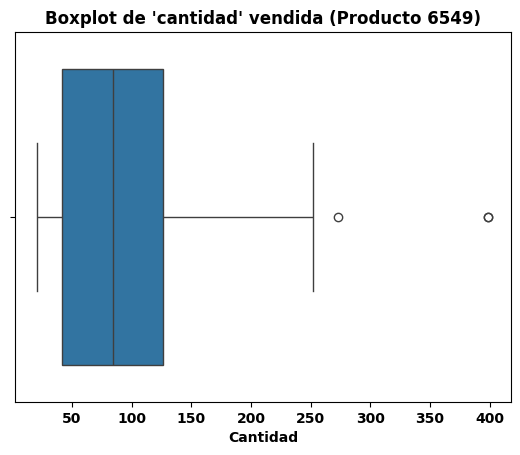

In [73]:
# Boxplot para ver outliers, hay que pasarlo a pandas tambi√©n
import seaborn as sns

sns.boxplot(x=df_6549["cantidad"].to_pandas())
plt.title("Boxplot de 'cantidad' vendida (Producto 6549)")
plt.xlabel("Cantidad")
plt.savefig(os.path.join(PLOTS_EDA_DIR, "boxplot_6549"), dpi=300)
plt.show()




In [35]:
# Mostramos valores de esos outliers
print(outliers_6549[["fecha_venta", "cantidad"]])

shape: (3, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ fecha_venta ‚îÜ cantidad ‚îÇ
‚îÇ ---         ‚îÜ ---      ‚îÇ
‚îÇ date        ‚îÜ f64      ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2022-12-24  ‚îÜ 399.0    ‚îÇ
‚îÇ 2022-12-31  ‚îÜ 399.0    ‚îÇ
‚îÇ 2023-02-25  ‚îÜ 273.0    ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


In [ ]:
# Vamos a intentar hacer una funci√≥n que detecte todos los outliers del dataset

def get_outliers_product(df, columna_producto="articulo", columna_valor="cantidad"):
    outliers_list = []
    products = df[columna_producto].unique().to_list()

    for prod in products:
        subdf = df.filter(pl.col(columna_producto) == prod)
        if subdf.shape[0] < 5:
            continue   # Ignora productos con pocos datos

        q1 = subdf[columna_valor].quantile(0.25)
        q3 = subdf[columna_valor].quantile(0.75)
        iqr = q3 - q1
        lim_inf = q1 - 1.5 * iqr
        lim_sup = q3 - 1.5 * iqr

        outliers = subdf.filter((pl.col(columna_valor) < lim_inf) | (pl.col(columna_valor) > lim_sup))
        if outliers.shape[0] > 0:
            outliers_list.append(outliers)

    if outliers_list:
        return pl.concat(outliers_list)
    else:
        return pl.DataFrame([])
    
# Probamos la funci√≥n
all_outliers = get_outliers_product(df)
print(f"N√∫mero total de outliers en todo el dataset: {all_outliers.shape[0]}")
all_outliers.head()

N√∫mero total de outliers en todo el dataset: 9853


shape: (5, 15)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ familia   ‚îÜ articulo ‚îÜ fecha_venta ‚îÜ festivo         ‚îÜ ‚Ä¶ ‚îÜ prcp_w ‚îÜ wdir_w ‚îÜ wspd_w ‚îÜ pres_w ‚îÇ
‚îÇ ---       ‚îÜ ---      ‚îÜ ---         ‚îÜ ---             ‚îÜ   ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÇ
‚îÇ str       ‚îÜ i64      ‚îÜ date        ‚îÜ str             ‚îÜ   ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ PANADERIA ‚îÜ 417      ‚îÜ 2021-05-01  ‚îÜ null            ‚îÜ ‚Ä¶ ‚îÜ 0.0    ‚îÜ null   ‚îÜ 14.2   ‚îÜ 1014.0 ‚îÇ
‚îÇ PANADERIA ‚îÜ 417      ‚îÜ 2021-05-02  ‚îÜ D√≠a de la Madre ‚îÜ ‚Ä¶ ‚îÜ 0.0    ‚îÜ null   ‚îÜ 15.7   ‚îÜ 1015.9 ‚îÇ
‚îÇ PANADERIA ‚îÜ 417      ‚îÜ 2021-05-03  ‚îÜ D√≠a de la Cruz  ‚îÜ ‚Ä¶ ‚îÜ 6.5    ‚îÜ null   ‚îÜ 9.7    ‚îÜ 1017.7 ‚îÇ
‚îÇ PANADERIA ‚îÜ 417      ‚îÜ 2021-05-04  ‚îÜ null            ‚îÜ ‚Ä¶ ‚îÜ 0.0    ‚îÜ null   ‚îÜ 12.1   ‚îÜ 1018.0 ‚îÇ
‚îÇ PANADERIA ‚îÜ 417      ‚îÜ 2021-05-05  ‚îÜ null            ‚îÜ ‚Ä¶ ‚îÜ 0.0    ‚îÜ null   ‚îÜ 13.8   ‚îÜ 1016.5 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [ ]:
# Porcentaje total de outliers en el dataset 
print(f"Porcentaje de outliers: {100 * all_outliers.shape[0] / df.shape[0]:.2f}%")


Porcentaje de outliers: 93.18%


### Sobre los outliers detectados en "cantidad"

Al aplicar el m√©todo cl√°sico de outliers (usando el rango intercuart√≠lico o IQR), hemos visto que m√°s del **90% de las observaciones** son marcadas como outliers. Esto no significa necesariamente que haya errores en los datos, sino que la distribuci√≥n de "cantidad" es **muy desigual**. En ventas reales es habitual encontrar:

- Muchos d√≠as con ventas cero (lo que estrecha el IQR).
- D√≠as puntuales con pedidos altos por promociones, eventos o simplemente variabilidad normal.
- Grandes diferencias entre productos (algunos con ventas constantes y otros casi nunca).

Por eso, el m√©todo IQR cl√°sico se vuelve **demasiado sensible** en este contexto y marca como outlier la mayor√≠a de las ventas.  
En estos casos, conviene revisar los datos visualmente y, si es necesario, ajustar el m√©todo (por ejemplo, usando un umbral m√°s amplio, percentiles, o solo revisando los casos extremos).

La mayor√≠a de estos "outliers" probablemente sean ventas v√°lidas y reflejan la realidad de los datos, no errores.**


In [37]:
# Funci√≥n para contar outliers por producto (usando 1.5 x IQR)
def count_outliers_per_product(df, columna_producto="articulo", columna_valor="cantidad"):
    summary = []
    products = df[columna_producto].unique().to_list()
    for prod in products:
        subdf = df.filter(pl.col(columna_producto) == prod)
        if subdf.shape[0] < 5:
            continue
        q1 = subdf[columna_valor].quantile(0.25)
        q3 = subdf[columna_valor].quantile(0.75)
        iqr = q3 - q1
        lim_inf = q1 - 1.5 * iqr
        lim_sup = q3 + 1.5 * iqr
        n_outliers = subdf.filter((pl.col(columna_valor) < lim_inf) | (pl.col(columna_valor) > lim_sup)).shape[0]
        summary.append({"articulo": prod, "outliers_cantidad": n_outliers, "n_total": subdf.shape[0]})
    return pl.DataFrame(summary)

# Ejecuto y muestro la tabla
table_outliers = count_outliers_per_product(df)
table_outliers = table_outliers.with_columns(
    (pl.col("outliers_cantidad") / pl.col("n_total") * 100).alias("porcentaje_outliers")
)
table_outliers = table_outliers.sort("porcentaje_outliers", descending=True)

print(table_outliers)


shape: (15, 4)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ articulo ‚îÜ outliers_cantidad ‚îÜ n_total ‚îÜ porcentaje_outliers ‚îÇ
‚îÇ ---      ‚îÜ ---               ‚îÜ ---     ‚îÜ ---                 ‚îÇ
‚îÇ i64      ‚îÜ i64               ‚îÜ i64     ‚îÜ f64                 ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 6286     ‚îÜ 59                ‚îÜ 746     ‚îÜ 7.908847            ‚îÇ
‚îÇ 5803     ‚îÜ 53                ‚îÜ 745     ‚îÜ 7.114094            ‚îÇ
‚îÇ 5403     ‚îÜ 37                ‚îÜ 641     ‚îÜ 5.772231            ‚îÇ
‚îÇ 6523     ‚îÜ 36                ‚îÜ 699     ‚îÜ 5.150215            ‚îÇ
‚îÇ 3880     ‚îÜ 38                ‚îÜ 748     ‚îÜ 5.080214            ‚îÇ

In [38]:
# Miro los 5 productos con mayor porcentaje de outliers
top_5_outliers = table_outliers.head(5)

print("Top 5 productos con mayor % de outliers en 'cantidad':")
print(top_5_outliers)


Top 5 productos con mayor % de outliers en 'cantidad':
shape: (5, 4)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ articulo ‚îÜ outliers_cantidad ‚îÜ n_total ‚îÜ porcentaje_outliers ‚îÇ
‚îÇ ---      ‚îÜ ---               ‚îÜ ---     ‚îÜ ---                 ‚îÇ
‚îÇ i64      ‚îÜ i64               ‚îÜ i64     ‚îÜ f64                 ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 6286     ‚îÜ 59                ‚îÜ 746     ‚îÜ 7.908847            ‚îÇ
‚îÇ 5803     ‚îÜ 53                ‚îÜ 745     ‚îÜ 7.114094            ‚îÇ
‚îÇ 5403     ‚îÜ 37                ‚îÜ 641     ‚îÜ 5.772231            ‚îÇ
‚îÇ 6523     ‚îÜ 36                ‚îÜ 699     ‚îÜ 5.150215            ‚îÇ
‚îÇ 3880     ‚îÜ 38 

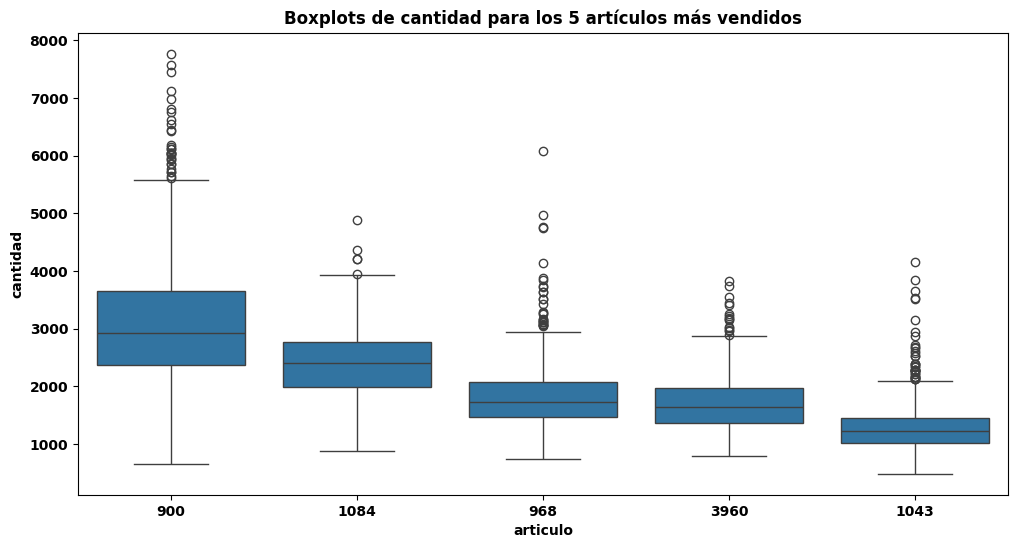

In [74]:
# Vamos a visualizar m√°s Boxplots para los productos top
top_items = df.group_by("articulo").agg(pl.col("cantidad").sum()).sort("cantidad", descending=True)["articulo"].to_list()[:5]

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=pd.concat([df.filter(pl.col("articulo") == art).select(["cantidad"]).to_pandas().assign(articulo=str(art)) for art in top_items]),
    x="articulo",
    y="cantidad"
)
plt.title("Boxplots de cantidad para los 5 art√≠culos m√°s vendidos")
plt.savefig(os.path.join(PLOTS_EDA_DIR, "boxplots_outliers_top5_products"), dpi=300)
plt.show()

### Boxplot de cantidades para los 5 art√≠culos m√°s vendidos
El gr√°fico muestra la dispersi√≥n diaria de ventas para los cinco productos m√°s vendidos.
Se aprecian diferencias de escala y numerosos outliers, lo que indica d√≠as con ventas an√≥malamente altas.
Este an√°lisis ayuda a identificar variabilidad y detectar posibles anomal√≠as en los datos de ventas.

#### 4.2. An√°lisis de la variable a predecir

Este apartado tiene como cometido comprender la evoluci√≥n de la variable "cantidad" en el tiempo y como se relaciona esta consigo misma.

**Grupo de preguntas 3** (x minutos):

7. Crea un gr√°fico de la evoluci√≥n temporal general de la variable "cantidad". Nota: Se debe de agrupar.

8. Crea un gr√°fico de la evoluci√≥n temporal por familia de la variable "cantidad". Nota: Se debe de agrupar.

9. Crea un gr√°fico de la evoluci√≥n temporal por art√≠culo de la variable "cantidad". Nota: Se debe de agrupar.

10. Se que hay mucho ruido, pero ¬øa simple vista crees que hay tendencia y/o estacionalidad en las series temporales anteriores?

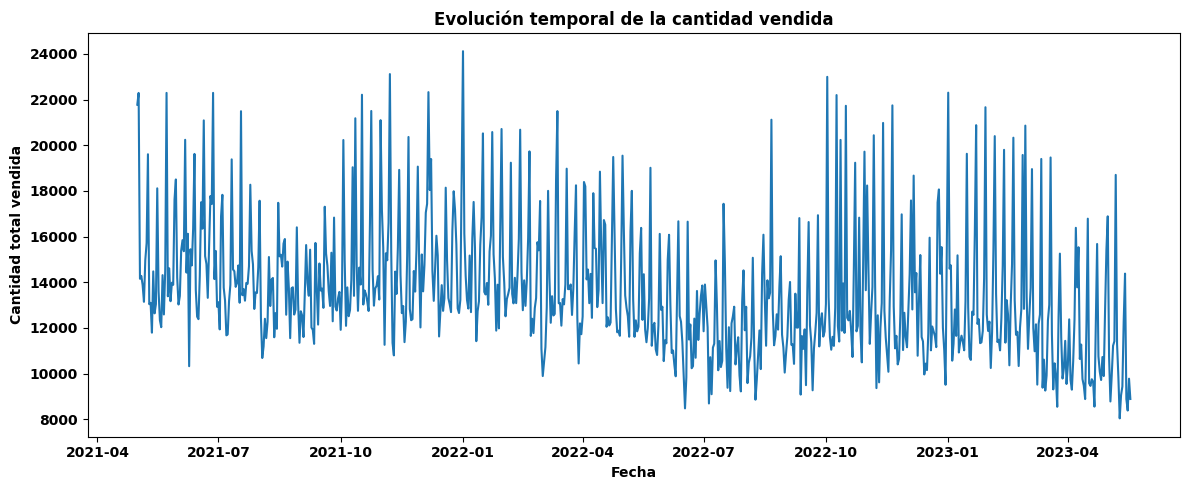

In [75]:
# 7_Evoluci√≥n temporal general de la variable "cantidad"

# Voy a agrupar por fecha y sumo la cantidad total vendida cada d√≠a
quantity_evo = (
    df.group_by("fecha_venta")
    .agg(pl.col("cantidad").sum().alias("cantidad_total"))
    .sort("fecha_venta")
)

# Paso a pandas para el plotting
plt.figure(figsize=(12, 5))
plt.plot(quantity_evo["fecha_venta"].to_pandas(), quantity_evo["cantidad_total"].to_pandas())
plt.title("Evoluci√≥n temporal de la cantidad vendida")
plt.xlabel("Fecha")
plt.ylabel("Cantidad total vendida")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "total_quantity_sales"), dpi=300)
plt.show()

#### Evoluci√≥n temporal de la cantidad vendida

El gr√°fico muestra la evoluci√≥n diaria de la cantidad total vendida en la panader√≠a durante el periodo analizado.  
Se aprecia bastante ruido en las ventas diarias y no se observa una tendencia clara a simple vista, aunque podr√≠a haber patrones estacionales o picos puntuales.  
Este comportamiento es habitual en negocios minoristas, donde factores como la demanda variable o eventos especiales afectan la serie temporal.


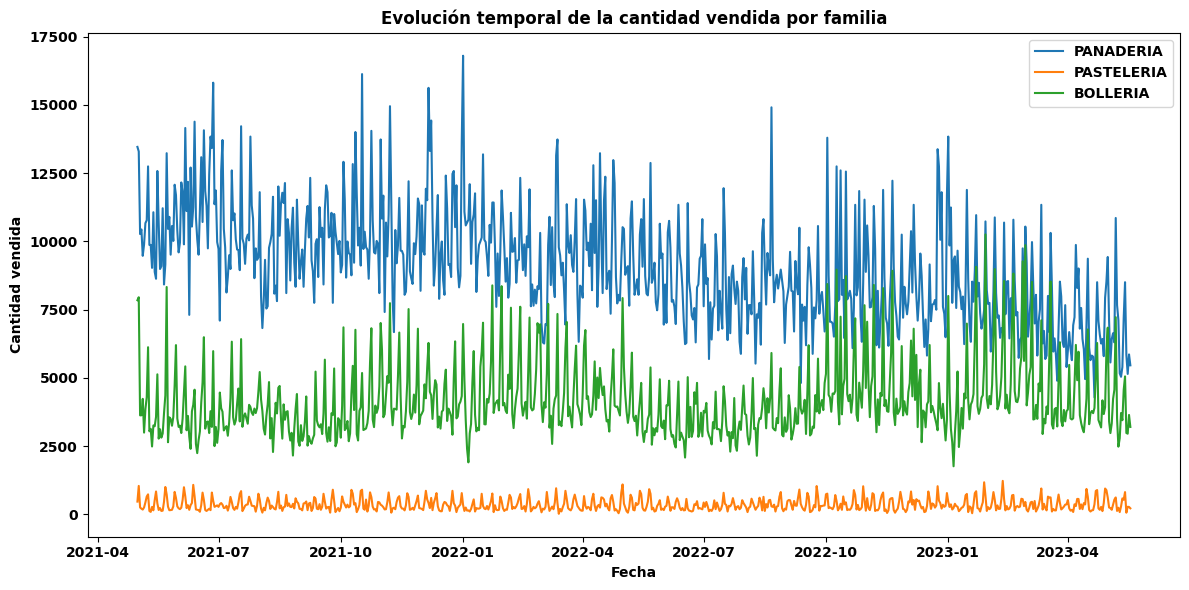

In [78]:
# 8_Evoluci√≥n temporal por familia de la variable "cantidad"

# Agrupar por fecha y familia
agg_familia = (
    df.group_by(["fecha_venta", "familia"])
    .agg(pl.col("cantidad").sum().alias("cantidad_total"))
    .sort(["familia", "fecha_venta"])
)

familias = agg_familia["familia"].unique().to_list()

plt.figure(figsize=(12, 6))
for fam in familias:
    data = agg_familia.filter(pl.col("familia") == fam)
    plt.plot(data["fecha_venta"].to_pandas(), data["cantidad_total"].to_pandas(), label=fam)
plt.title("Evoluci√≥n temporal de la cantidad vendida por familia")
plt.xlabel("Fecha")
plt.ylabel("Cantidad vendida")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "total_sales_per_family"), dpi=300)
plt.show()   

#### Evoluci√≥n temporal de la cantidad vendida por familia

La gr√°fica muestra c√≥mo evoluciona la cantidad total vendida a lo largo del tiempo para cada familia de productos.  
Se observan diferencias claras en el volumen y el comportamiento de ventas seg√∫n la familia, con algunas presentando m√°s variabilidad o picos en fechas concretas.  
Este an√°lisis ayuda a identificar patrones espec√≠ficos y posibles oportunidades de mejora para cada l√≠nea de producto.

Destaca especialmente la familia PANADER√çA, que muestra un volumen de ventas mucho mayor y una mayor estabilidad/picos a lo largo del tiempo, en comparaci√≥n con el resto de familias. Este comportamiento puede deberse a la popularidad del producto, promociones espec√≠ficas, una mayor demanda en ciertos periodos, o simplemente que son productos disponibles cada d√≠a, a excepci√≥n de otros de las dem√°s familias.


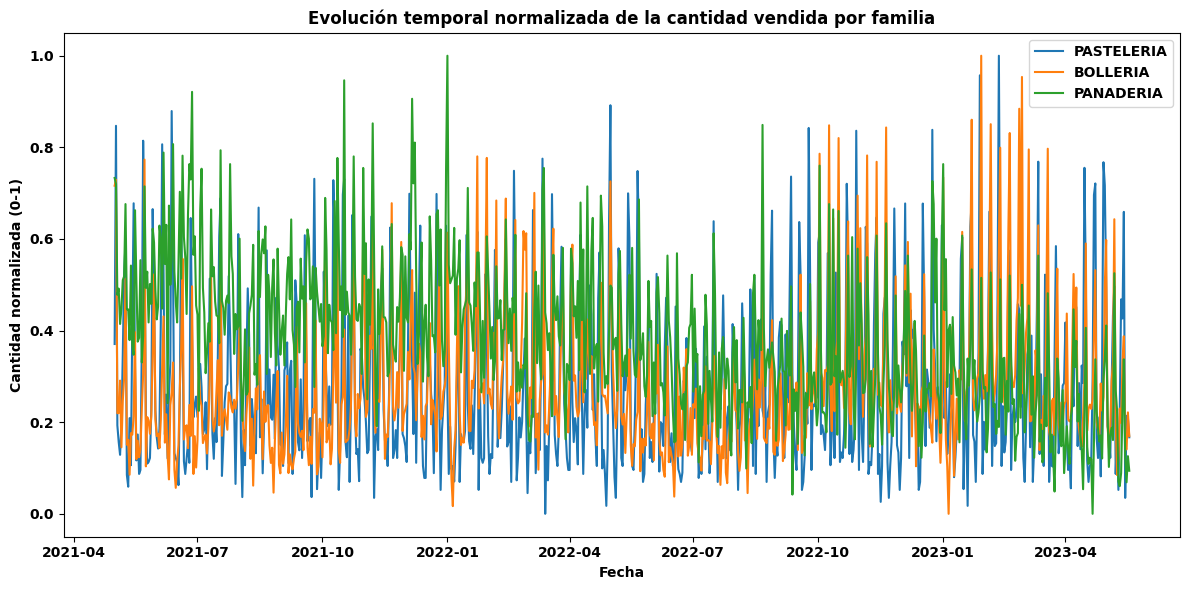

In [81]:
# Normalizamos la variable "cantidad", para una f√°cil comparaci√≥n aunque tengan escalas muy diferents las familias
from sklearn.preprocessing import MinMaxScaler

# Primero agrupamos por familia y fecha (como antes)
agg_familia = (
    df.group_by(["fecha_venta", "familia"])
      .agg(pl.col("cantidad").sum().alias("cantidad_total"))
      .sort(["familia", "fecha_venta"])
)

# Normaliza la cantidad para cada familia (0-1)
result = []
for fam in agg_familia["familia"].unique().to_list():
    sub = agg_familia.filter(pl.col("familia") == fam)
    scaler = MinMaxScaler()
    cantidades_norm = scaler.fit_transform(sub["cantidad_total"].to_numpy().reshape(-1,1)).flatten()
    temp_df = sub.with_columns([
        pl.Series("cantidad_norm", cantidades_norm)
    ])
    result.append(temp_df)

agg_norm = pl.concat(result)

# Plot
plt.figure(figsize=(12,6))
for fam in agg_norm["familia"].unique().to_list():
    datos = agg_norm.filter(pl.col("familia") == fam)
    plt.plot(datos["fecha_venta"].to_pandas(), datos["cantidad_norm"].to_pandas(), label=fam)
plt.title("Evoluci√≥n temporal normalizada de la cantidad vendida por familia")
plt.xlabel("Fecha")
plt.ylabel("Cantidad normalizada (0-1)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "total_sales_scaler_per_family"), dpi=300)
plt.show()


#### Evoluci√≥n temporal normalizada de la cantidad vendida por familia

En este gr√°fico, la cantidad vendida por cada familia de productos se ha normalizado entre 0 y 1, para facilitar la comparaci√≥n de patrones y tendencias independientemente del volumen de ventas. 

La normalizaci√≥n permite observar similitudes o diferencias en la evoluci√≥n relativa de cada familia a lo largo del tiempo, destacando posibles efectos estacionales o comportamientos sincronizados entre productos.

> **Interpretaci√≥n de la evoluci√≥n temporal normalizada por familia:**  
> 
> Las tres familias (PASTELERIA, BOLLERIA y PANADERIA) presentan una evoluci√≥n diaria con mucha variabilidad y sin una tendencia clara a largo plazo.  
> No se observan picos sincronizados fuertes ni patrones de estacionalidad evidentes entre las familias: sus m√°ximos y m√≠nimos aparecen en fechas distintas.  
> La demanda parece estar influida m√°s por factores espec√≠ficos de cada producto que por patrones generales o estacionales.  
> En resumen, cada familia evoluciona de forma relativamente independiente y con bastante ruido d√≠a a d√≠a.



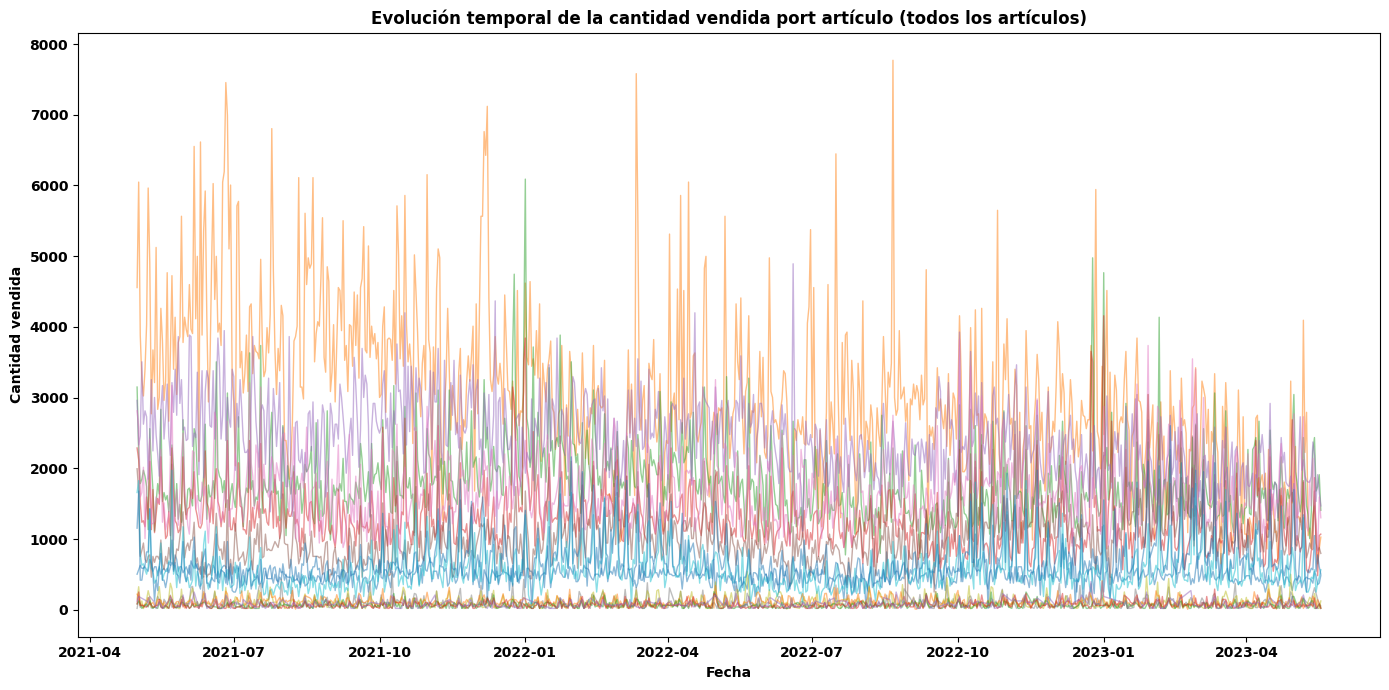

In [86]:
# 9_Evoluci√≥n temporal por art√≠culo de la variable "cantidad"

# Agrupar por fecha y art√≠culo
agg_articulos = (
    df.group_by(["fecha_venta", "articulo"])
    .agg(pl.col("cantidad").sum().alias("cantidad_total"))
    .sort(["articulo", "fecha_venta"])
)

# Art√≠culos √∫nicos
all_items = agg_articulos["articulo"].unique().to_list()

# Plotting
plt.figure(figsize=(14, 7))
for item in all_items:
    data = agg_articulos.filter(pl.col("articulo") == item)
    plt.plot(data["fecha_venta"].to_pandas(), data["cantidad_total"].to_pandas(), alpha=0.5, linewidth=1)
plt.title("Evoluci√≥n temporal de la cantidad vendida port art√≠culo (todos los art√≠culos)") 
plt.xlabel("Fecha")
plt.ylabel("Cantidad vendida")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "total_sales_per_item"), dpi=300)
plt.show()



### Evoluci√≥n temporal de la cantidad vendida por art√≠culo

En este gr√°fico se representa la evoluci√≥n diaria de la cantidad vendida para **cada art√≠culo** del cat√°logo. Cada l√≠nea corresponde a un art√≠culo distinto.

Como era de esperar, el gr√°fico muestra un alto nivel de ruido visual debido al gran n√∫mero de art√≠culos representados, lo que hace que resulte dif√≠cil identificar patrones concretos para productos individuales. Sin embargo, esta visualizaci√≥n global es √∫til para hacerse una idea general del comportamiento conjunto, detectar picos generales de demanda o posibles anomal√≠as a nivel agregado.

> **Nota:** Por motivos de claridad, no se ha incluido una leyenda para cada art√≠culo, ya que har√≠a el gr√°fico ilegible. Para un an√°lisis m√°s detallado, es recomendable seleccionar art√≠culos concretos y analizar sus series de forma individual.


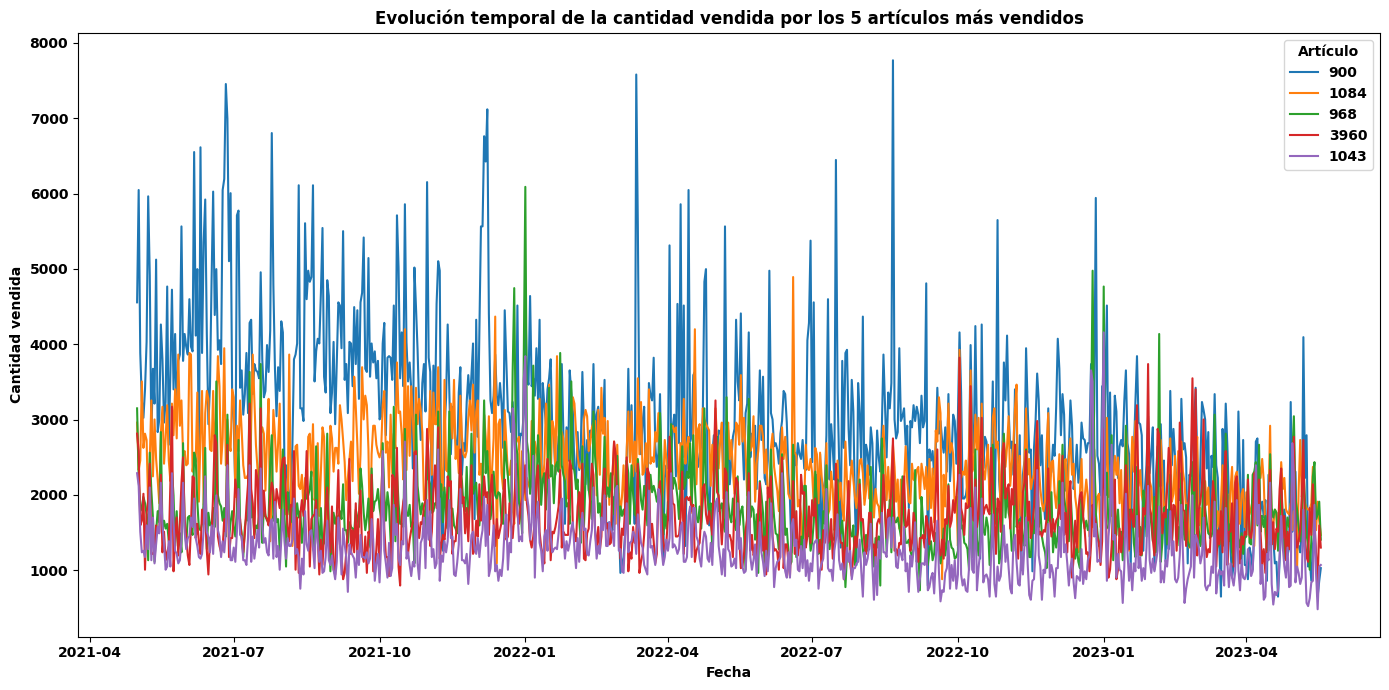

In [87]:
# Me voy a centrar en los art√≠culos m√°s vendidos para recibir un ploteo m√°s limpio

# Top 5 art√≠culos m√°s vendidos
best_five_items = (
    df.group_by("articulo")
    .agg(pl.col("cantidad").sum().alias("cantidad_total"))
    .sort("cantidad_total", descending=True)
    .head(5)["articulo"]
    .to_list()
)

# Filtro con art√≠culos top
df_top = df.filter(pl.col("articulo").is_in(best_five_items))

# Ploteo
plt.figure(figsize=(14, 7))
for item in best_five_items:
    data = agg_articulos.filter(pl.col("articulo") == item)
    plt.plot(data["fecha_venta"].to_pandas(), data["cantidad_total"].to_pandas(), label=str(item))
plt.title("Evoluci√≥n temporal de la cantidad vendida por los 5 art√≠culos m√°s vendidos")
plt.xlabel("Fecha")
plt.ylabel("Cantidad vendida")
plt.legend(title="Art√≠culo")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "total_sales_top5_items"), dpi=300)
plt.show()



### Evoluci√≥n temporal de la cantidad vendida para los 5 art√≠culos m√°s vendidos

Este gr√°fico muestra la evoluci√≥n diaria de la cantidad vendida para los cinco art√≠culos m√°s vendidos de la panader√≠a.

Cada l√≠nea representa un art√≠culo diferente, lo que permite comparar visualmente su comportamiento a lo largo del tiempo.  
Se observan **altos niveles de variabilidad** y picos pronunciados, lo que puede estar relacionado con la demanda estacional, promociones o eventos puntuales.

Este enfoque facilita detectar tendencias y posibles patrones para los productos m√°s relevantes, a diferencia del gr√°fico global donde el exceso de l√≠neas dificulta el an√°lisis detallado.


### 10. ¬øA simple vista crees que hay tendencia y/o estacionalidad en las series temporales anteriores?

A simple vista, las series temporales analizadas muestran **mucho ruido** y una alta variabilidad diaria.  
No se aprecia una tendencia clara de aumento o descenso sostenido en la cantidad vendida para la mayor√≠a de productos o familias.

Sin embargo, **s√≠ parece haber cierta estacionalidad**: se observan repuntes y ca√≠das recurrentes en varios periodos, especialmente en los productos m√°s vendidos.  
Estas fluctuaciones podr√≠an estar asociadas a fines de semana, festivos, campa√±as especiales o √©pocas del a√±o concretas.

Para confirmar la presencia de tendencia o estacionalidad, ser√≠a recomendable aplicar t√©cnicas estad√≠sticas como la descomposici√≥n de series temporales o el an√°lisis de autocorrelaci√≥n.


**Grupo de preguntas 4** (x minutos):

11. Aplica alguna t√©cnica estad√≠stica para observar si hay estacionalidad en la evolucion temporal general de la variable "cantidad". Pista: Tomar la primera diferencia y, despu√©s, hacer un analisis de autocorrelaci√≥n.

12. Sin aplicar la primera diferencia y creando nuevas columnas de fecha a partir de la variable "fecha_venta" (semana del a√±o, mes del a√±o, d√≠a de la semana, d√≠a del mes, d√≠a del a√±o) comprueba realizando diferentes agrupaciones y gr√°ficos si nuestro an√°lisis de autocorrelaci√≥n de nuestra variable cantidad nos mostraba lo correcto. Si encuentras alg√∫n gr√°fico que te llame la atenci√≥n, baja el nivel del an√°lisis (Ej: 1. Cantidad general -> 2. Cantidad por familia -> 3. Cantidad por art√≠culo).

In [ ]:
# 11
# Check si el proceso es estacionario

def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: ', result[0])
    print('p-value: ', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32m Stationary \u001b[0m")
    else:
        print("\x1b[31m Non-stationary \x1b[0m")

group = df.groupby([pd.Grouper(key="fecha_venta", freq="1D")])["cantidad"].sum().reset_index()
check_stationarity(group["cantidad"])
fig = px.line(group, x="fecha_venta", y="cantidad")
fig.show()

In [ ]:
# 11
# Tomando la primera diferencia

# Podemos tomar la primera diferencia para observar si nuestra serie se convierte en estacionaria.
# Esto elimina tendencias y estabiliza la varianza de la serie, permitiendo que sea modelada.

group["cantidad_diff"] = group["cantidad"].diff().fillna(0)
check_stationarity(group["cantidad_diff"])

In [ ]:
# 11
# La nueva serie temporal tiene esta pinta

fig = px.line(group, x="fecha_venta", y="cantidad_diff")
fig.show()

In [ ]:
# 11
# Analisis de autocorrelaci√≥n

# En terminos generales, este gr√°fico nos indica que un valor de cantidad esta
# directamente relacionado con su valor de cantidad anterior y su valor de cantidad de la semana pasada.
# Parece que hay estacionalidad semanal.

plot_acf(group["cantidad_diff"],lags=56)
plt.tight_layout()
plt.show()

In [ ]:
# 12

# Semana y mes del a√±o
df["weekofyear"] = df["fecha_venta"].dt.isocalendar().week
df["monthofyear"] = df["fecha_venta"].dt.month

# D√≠a de la semana, del mes y del a√±o
df["dayofweek"] = df["fecha_venta"].dt.b #Lunes 0 y Domingo 6
df["dayofmonth"] = df["fecha_venta"].dt.day
df["dayofyear"] = df["fecha_venta"].dt.dayofyear

def graph_by_freq(freq, breakdown="familia", norm=False):
    group = df.groupby([breakdown, freq], as_index=False)["cantidad"].sum()

    if norm == True:
        group['cantidad'] = group.groupby(breakdown)['cantidad'].transform(normalize)

    fig = px.line(group, x=freq, y="cantidad", color=breakdown, markers=True)
    fig.show()

# A nivel familia
graph_by_freq("dayofweek")

# Como nos encontramos en nuestro an√°lisis de autocorrelaci√≥n,
# los valores de cantidad podr√≠an tener una relaci√≥n con su valor de la semana pasada
# debido a que hay un patr√≥n de compra semanal que se repite en el tiempo.

In [ ]:
# 12

# A nivel articulo
graph_by_freq("dayofweek", "articulo")

In [ ]:
# 12
# Gr√°ficos caja

fig = px.box(df, x="dayofweek", y="cantidad", color='familia')
fig.show()

In [ ]:
graph_by_freq("monthofyear")

*****

#### 4.3. An√°lisis de la variable a predecir frente al resto de variables

**Grupo de preguntas 5** (x minutos):

13. ¬øEl comportamiento de compra (la variable "cantidad") cuando es festivo es superior a cuando no lo es?

14. ¬øEl comportamiento de compra (la variable "cantidad") cuando llueve es superior a cuando no llueve?

15. Divide la variable "tavg_w" en quintiles y muestra con un gr√°fico de barras s√≠ la variable "cantidad" es superior en alguno de sus quintiles.

In [ ]:
# 13

# 1 si es festivo, 0 si no lo es
df['es_festivo'] = df['festivo'].apply(lambda x: 0 if x is None else 1)

fig = px.box(df, x="es_festivo", y="cantidad", color='familia')
fig.show()

# El comportamiento de compra cuando es festivo parece ligeramente superior

In [ ]:
# 14

# 1 si llueve, 0 si no llueve
df["lluvia"] = np.where(df["prcp_w"] > 0, 1, 0)

fig = px.box(df, x="lluvia", y="cantidad", color='familia')
fig.show()

# Parece que la lluvia no es un impedimiento para comprar

In [ ]:
# 15

labels_tavg = ['Temperatura muy baja',
               'Temperatura baja',
               'Temperatura normal',
               'Temperatura alta',
               'Temperatura muy alta']

df['quintiles_tavg_w'] = pd.qcut(df['tavg_w'], q=5, labels=labels_tavg)

group = df.groupby(["familia", "quintiles_tavg_w"])["cantidad"].sum().reset_index()
fig = px.bar(group, x='quintiles_tavg_w', y='cantidad', color="familia",barmode='group')
fig.show()

**Grupo de preguntas 6** (x minutos):

16. ¬øUn incremento en el precio reduce la propensi√≥n a consumir de un art√≠culo?

In [ ]:
# 16

def function_variations(x):
    list_unique = x.unique()
    len_list = len(list_unique)

    if len_list > 1:
        return 1
    else:
        return 0

group = df.groupby(["articulo",
                    pd.Grouper(key="fecha_venta", freq="1M"),
                    "familia"]).agg({"cantidad": "sum",
                                     "precio": function_variations}).reset_index()

group["precio"] = group.groupby("articulo")["precio"].transform("cumsum")
group["precio"] = group["precio"].astype(object)

fig = px.box(group, x="precio", y="cantidad", color='articulo')
fig.show()

# No es concluyente debido a que puede haber una tendencia negativa/positiva en el consumo general del articulo
# a lo largo del tiempo, pero es interesante observar como muchas veces si que tiene un impacto negativo
# (productos: 417, 1043, 1084, 3960, 5403).
# Podr√≠a ser tambi√©n por la canibalizaci√≥n de nuevos productos a otros anteriores.

*****